In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "400X"
trainable_blocks = ["block4"]
irun = 5


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_400X-BREAKHIS-Dataset-60-10-30-VGGINet/5'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/400X/5'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 971 files belonging to 2 classes.


Found 161 files belonging to 2 classes.


Found 488 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/8 [==>...........................] - ETA: 0s - loss: 1.4578 - accuracy: 0.4297

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/8 [======>.......................] - ETA: 6s - loss: 3.5863 - accuracy: 0.6016

3/8 [==========>...................] - ETA: 6s - loss: 4.5057 - accuracy: 0.6510

4/8 [==============>...............] - ETA: 6s - loss: 4.7544 - accuracy: 0.6875

5/8 [=================>............] - ETA: 4s - loss: 4.8531 - accuracy: 0.6891

6/8 [=====================>........] - ETA: 2s - loss: 4.8376 - accuracy: 0.6901

7/8 [=========================>....] - ETA: 1s - loss: 5.0426 - accuracy: 0.6853

8/8 [==============================] - ETA: 0s - loss: 4.7888 - accuracy: 0.7034

8/8 [==============================] - 22s 3s/step - loss: 4.7888 - accuracy: 0.7034 - val_loss: 20.8050 - val_accuracy: 0.7950


Epoch 2/100


1/8 [==>...........................] - ETA: 0s - loss: 5.5135 - accuracy: 0.7891

2/8 [======>.......................] - ETA: 12s - loss: 5.0494 - accuracy: 0.7891

3/8 [==========>...................] - ETA: 8s - loss: 4.0716 - accuracy: 0.8151 

4/8 [==============>...............] - ETA: 7s - loss: 3.8175 - accuracy: 0.8164

5/8 [=================>............] - ETA: 5s - loss: 3.5690 - accuracy: 0.8203

6/8 [=====================>........] - ETA: 3s - loss: 3.5012 - accuracy: 0.8190

7/8 [=========================>....] - ETA: 1s - loss: 3.4168 - accuracy: 0.8248

8/8 [==============================] - ETA: 0s - loss: 3.2338 - accuracy: 0.8332

8/8 [==============================] - 14s 2s/step - loss: 3.2338 - accuracy: 0.8332 - val_loss: 4.6217 - val_accuracy: 0.9006


Epoch 3/100


1/8 [==>...........................] - ETA: 0s - loss: 1.4189 - accuracy: 0.8984

2/8 [======>.......................] - ETA: 14s - loss: 1.7734 - accuracy: 0.8867

3/8 [==========>...................] - ETA: 11s - loss: 1.8363 - accuracy: 0.8776

4/8 [==============>...............] - ETA: 8s - loss: 2.3504 - accuracy: 0.8496 

5/8 [=================>............] - ETA: 5s - loss: 2.3958 - accuracy: 0.8453

6/8 [=====================>........] - ETA: 3s - loss: 2.2780 - accuracy: 0.8464

7/8 [=========================>....] - ETA: 1s - loss: 2.1587 - accuracy: 0.8527

8/8 [==============================] - ETA: 0s - loss: 2.0599 - accuracy: 0.8589

8/8 [==============================] - 14s 2s/step - loss: 2.0599 - accuracy: 0.8589 - val_loss: 2.9523 - val_accuracy: 0.9006


Epoch 4/100


1/8 [==>...........................] - ETA: 0s - loss: 2.4173 - accuracy: 0.8203

2/8 [======>.......................] - ETA: 2s - loss: 1.6291 - accuracy: 0.8750

3/8 [==========>...................] - ETA: 3s - loss: 1.4158 - accuracy: 0.8828

4/8 [==============>...............] - ETA: 4s - loss: 1.5952 - accuracy: 0.8672

5/8 [=================>............] - ETA: 3s - loss: 1.5511 - accuracy: 0.8672

6/8 [=====================>........] - ETA: 2s - loss: 1.6768 - accuracy: 0.8620

7/8 [=========================>....] - ETA: 1s - loss: 1.6381 - accuracy: 0.8616

8/8 [==============================] - ETA: 0s - loss: 1.6627 - accuracy: 0.8589

8/8 [==============================] - 11s 1s/step - loss: 1.6627 - accuracy: 0.8589 - val_loss: 1.8031 - val_accuracy: 0.9130


Epoch 5/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9290 - accuracy: 0.9062

2/8 [======>.......................] - ETA: 11s - loss: 0.9866 - accuracy: 0.9023

3/8 [==========>...................] - ETA: 8s - loss: 1.1107 - accuracy: 0.8854 

4/8 [==============>...............] - ETA: 7s - loss: 1.2034 - accuracy: 0.8848

5/8 [=================>............] - ETA: 4s - loss: 1.3822 - accuracy: 0.8828

6/8 [=====================>........] - ETA: 3s - loss: 1.4332 - accuracy: 0.8763

7/8 [=========================>....] - ETA: 1s - loss: 1.3211 - accuracy: 0.8839

8/8 [==============================] - ETA: 0s - loss: 1.2929 - accuracy: 0.8847

8/8 [==============================] - 14s 2s/step - loss: 1.2929 - accuracy: 0.8847 - val_loss: 1.8016 - val_accuracy: 0.9255


Epoch 6/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1775 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.9007 - accuracy: 0.8945

3/8 [==========>...................] - ETA: 8s - loss: 0.9672 - accuracy: 0.8880 

4/8 [==============>...............] - ETA: 7s - loss: 0.9817 - accuracy: 0.8887

5/8 [=================>............] - ETA: 4s - loss: 1.1248 - accuracy: 0.8859

6/8 [=====================>........] - ETA: 3s - loss: 1.0864 - accuracy: 0.8880

7/8 [=========================>....] - ETA: 1s - loss: 1.2517 - accuracy: 0.8839

8/8 [==============================] - ETA: 0s - loss: 1.2396 - accuracy: 0.8877

8/8 [==============================] - 14s 2s/step - loss: 1.2396 - accuracy: 0.8877 - val_loss: 1.2017 - val_accuracy: 0.9193


Epoch 7/100


1/8 [==>...........................] - ETA: 0s - loss: 1.4682 - accuracy: 0.8672

2/8 [======>.......................] - ETA: 11s - loss: 1.9362 - accuracy: 0.8281

3/8 [==========>...................] - ETA: 8s - loss: 1.5104 - accuracy: 0.8646 

4/8 [==============>...............] - ETA: 7s - loss: 1.3207 - accuracy: 0.8711

5/8 [=================>............] - ETA: 4s - loss: 1.2828 - accuracy: 0.8687

6/8 [=====================>........] - ETA: 3s - loss: 1.2144 - accuracy: 0.8789

7/8 [=========================>....] - ETA: 1s - loss: 1.1997 - accuracy: 0.8828

8/8 [==============================] - ETA: 0s - loss: 1.1689 - accuracy: 0.8847

8/8 [==============================] - 14s 2s/step - loss: 1.1689 - accuracy: 0.8847 - val_loss: 1.8391 - val_accuracy: 0.8758


Epoch 8/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9945 - accuracy: 0.9141

2/8 [======>.......................] - ETA: 11s - loss: 1.8559 - accuracy: 0.8828

3/8 [==========>...................] - ETA: 8s - loss: 1.5145 - accuracy: 0.8958 

4/8 [==============>...............] - ETA: 7s - loss: 1.3766 - accuracy: 0.9004

5/8 [=================>............] - ETA: 4s - loss: 1.2547 - accuracy: 0.9078

6/8 [=====================>........] - ETA: 3s - loss: 1.1775 - accuracy: 0.9062

7/8 [=========================>....] - ETA: 1s - loss: 1.2101 - accuracy: 0.9096

8/8 [==============================] - ETA: 0s - loss: 1.2593 - accuracy: 0.9053

8/8 [==============================] - 14s 2s/step - loss: 1.2593 - accuracy: 0.9053 - val_loss: 1.5451 - val_accuracy: 0.9255


Epoch 9/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2338 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 11s - loss: 1.0404 - accuracy: 0.9336

3/8 [==========>...................] - ETA: 8s - loss: 1.0728 - accuracy: 0.9297 

4/8 [==============>...............] - ETA: 7s - loss: 1.0216 - accuracy: 0.9316

5/8 [=================>............] - ETA: 4s - loss: 1.0275 - accuracy: 0.9234

6/8 [=====================>........] - ETA: 2s - loss: 0.9842 - accuracy: 0.9193

7/8 [=========================>....] - ETA: 1s - loss: 0.9597 - accuracy: 0.9196

8/8 [==============================] - ETA: 0s - loss: 0.9608 - accuracy: 0.9186

8/8 [==============================] - 14s 2s/step - loss: 0.9608 - accuracy: 0.9186 - val_loss: 2.0953 - val_accuracy: 0.8820


Epoch 10/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9272 - accuracy: 0.8828

2/8 [======>.......................] - ETA: 11s - loss: 0.9684 - accuracy: 0.8906

3/8 [==========>...................] - ETA: 8s - loss: 0.9729 - accuracy: 0.8984 

4/8 [==============>...............] - ETA: 7s - loss: 0.9709 - accuracy: 0.9082

5/8 [=================>............] - ETA: 5s - loss: 0.9419 - accuracy: 0.9141

6/8 [=====================>........] - ETA: 3s - loss: 1.0751 - accuracy: 0.9049

7/8 [=========================>....] - ETA: 1s - loss: 1.0573 - accuracy: 0.9085

8/8 [==============================] - ETA: 0s - loss: 1.1193 - accuracy: 0.9063

8/8 [==============================] - 14s 2s/step - loss: 1.1193 - accuracy: 0.9063 - val_loss: 1.5863 - val_accuracy: 0.9006


Epoch 11/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0366 - accuracy: 0.8906

2/8 [======>.......................] - ETA: 12s - loss: 0.9271 - accuracy: 0.8906

3/8 [==========>...................] - ETA: 8s - loss: 0.8994 - accuracy: 0.8984 

4/8 [==============>...............] - ETA: 8s - loss: 0.8019 - accuracy: 0.9062

5/8 [=================>............] - ETA: 5s - loss: 0.8288 - accuracy: 0.9031

6/8 [=====================>........] - ETA: 3s - loss: 0.8540 - accuracy: 0.9049

7/8 [=========================>....] - ETA: 1s - loss: 0.9641 - accuracy: 0.9029

8/8 [==============================] - ETA: 0s - loss: 0.9817 - accuracy: 0.9011

8/8 [==============================] - 15s 2s/step - loss: 0.9817 - accuracy: 0.9011 - val_loss: 1.2777 - val_accuracy: 0.9317


Epoch 12/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9145 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 11s - loss: 1.3091 - accuracy: 0.8789

3/8 [==========>...................] - ETA: 8s - loss: 1.1296 - accuracy: 0.8958 

4/8 [==============>...............] - ETA: 7s - loss: 1.0158 - accuracy: 0.8926

5/8 [=================>............] - ETA: 5s - loss: 1.0889 - accuracy: 0.8938

6/8 [=====================>........] - ETA: 3s - loss: 1.1049 - accuracy: 0.8919

7/8 [=========================>....] - ETA: 1s - loss: 1.1565 - accuracy: 0.8895

8/8 [==============================] - ETA: 0s - loss: 1.0748 - accuracy: 0.8960

8/8 [==============================] - 14s 2s/step - loss: 1.0748 - accuracy: 0.8960 - val_loss: 1.7205 - val_accuracy: 0.9068


Epoch 13/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7647 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 11s - loss: 0.8705 - accuracy: 0.9180

3/8 [==========>...................] - ETA: 8s - loss: 1.2185 - accuracy: 0.9167 

4/8 [==============>...............] - ETA: 7s - loss: 1.3667 - accuracy: 0.9082

5/8 [=================>............] - ETA: 5s - loss: 1.4575 - accuracy: 0.9000

6/8 [=====================>........] - ETA: 3s - loss: 1.3297 - accuracy: 0.9076

7/8 [=========================>....] - ETA: 1s - loss: 1.2588 - accuracy: 0.9062

8/8 [==============================] - ETA: 0s - loss: 1.2726 - accuracy: 0.9022

8/8 [==============================] - 14s 2s/step - loss: 1.2726 - accuracy: 0.9022 - val_loss: 1.1030 - val_accuracy: 0.9503


Epoch 14/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4357 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.5779 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 8s - loss: 0.5878 - accuracy: 0.9479 

4/8 [==============>...............] - ETA: 7s - loss: 0.8616 - accuracy: 0.9395

5/8 [=================>............] - ETA: 4s - loss: 0.9788 - accuracy: 0.9359

6/8 [=====================>........] - ETA: 3s - loss: 1.0893 - accuracy: 0.9245

7/8 [=========================>....] - ETA: 1s - loss: 1.1830 - accuracy: 0.9174

8/8 [==============================] - ETA: 0s - loss: 1.1077 - accuracy: 0.9207

8/8 [==============================] - 14s 2s/step - loss: 1.1077 - accuracy: 0.9207 - val_loss: 1.0571 - val_accuracy: 0.9379


Epoch 15/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8809 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 11s - loss: 1.0814 - accuracy: 0.9219

3/8 [==========>...................] - ETA: 8s - loss: 1.3638 - accuracy: 0.8932 

4/8 [==============>...............] - ETA: 7s - loss: 1.2401 - accuracy: 0.8926

5/8 [=================>............] - ETA: 4s - loss: 1.0424 - accuracy: 0.9062

6/8 [=====================>........] - ETA: 3s - loss: 1.1632 - accuracy: 0.8984

7/8 [=========================>....] - ETA: 1s - loss: 1.2356 - accuracy: 0.8973

8/8 [==============================] - ETA: 0s - loss: 1.1637 - accuracy: 0.9011

8/8 [==============================] - 14s 2s/step - loss: 1.1637 - accuracy: 0.9011 - val_loss: 1.0841 - val_accuracy: 0.9317


Epoch 16/100


1/8 [==>...........................] - ETA: 0s - loss: 1.5813 - accuracy: 0.8828

2/8 [======>.......................] - ETA: 22s - loss: 1.2809 - accuracy: 0.9062

3/8 [==========>...................] - ETA: 14s - loss: 1.2244 - accuracy: 0.9141

4/8 [==============>...............] - ETA: 10s - loss: 1.0788 - accuracy: 0.9219

5/8 [=================>............] - ETA: 6s - loss: 1.4005 - accuracy: 0.9047 

6/8 [=====================>........] - ETA: 4s - loss: 1.2703 - accuracy: 0.9089

7/8 [=========================>....] - ETA: 1s - loss: 1.3045 - accuracy: 0.9074

8/8 [==============================] - ETA: 0s - loss: 1.3511 - accuracy: 0.9022

8/8 [==============================] - 17s 2s/step - loss: 1.3511 - accuracy: 0.9022 - val_loss: 2.2590 - val_accuracy: 0.8571


Epoch 17/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2535 - accuracy: 0.8594

2/8 [======>.......................] - ETA: 11s - loss: 1.3553 - accuracy: 0.8750

3/8 [==========>...................] - ETA: 8s - loss: 1.0479 - accuracy: 0.8932 

4/8 [==============>...............] - ETA: 7s - loss: 1.1390 - accuracy: 0.8906

5/8 [=================>............] - ETA: 4s - loss: 1.1451 - accuracy: 0.8938

6/8 [=====================>........] - ETA: 3s - loss: 1.1217 - accuracy: 0.8984

7/8 [=========================>....] - ETA: 1s - loss: 1.0615 - accuracy: 0.9040

8/8 [==============================] - ETA: 0s - loss: 1.0509 - accuracy: 0.9094

8/8 [==============================] - 14s 2s/step - loss: 1.0509 - accuracy: 0.9094 - val_loss: 4.9311 - val_accuracy: 0.8199


Epoch 18/100


1/8 [==>...........................] - ETA: 0s - loss: 1.4323 - accuracy: 0.8672

2/8 [======>.......................] - ETA: 3s - loss: 1.8234 - accuracy: 0.8750

3/8 [==========>...................] - ETA: 8s - loss: 1.5984 - accuracy: 0.8984

4/8 [==============>...............] - ETA: 7s - loss: 1.3347 - accuracy: 0.9121

5/8 [=================>............] - ETA: 4s - loss: 1.3438 - accuracy: 0.9109

6/8 [=====================>........] - ETA: 3s - loss: 1.2891 - accuracy: 0.9089

7/8 [=========================>....] - ETA: 1s - loss: 1.2961 - accuracy: 0.9040

8/8 [==============================] - ETA: 0s - loss: 1.3100 - accuracy: 0.9011

8/8 [==============================] - 14s 2s/step - loss: 1.3100 - accuracy: 0.9011 - val_loss: 1.6883 - val_accuracy: 0.8944


Epoch 19/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5320 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 1.0294 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 8s - loss: 1.1266 - accuracy: 0.9349 

4/8 [==============>...............] - ETA: 7s - loss: 1.1252 - accuracy: 0.9316

5/8 [=================>............] - ETA: 5s - loss: 1.2600 - accuracy: 0.9250

6/8 [=====================>........] - ETA: 3s - loss: 1.3192 - accuracy: 0.9232

7/8 [=========================>....] - ETA: 1s - loss: 1.2703 - accuracy: 0.9230

8/8 [==============================] - ETA: 0s - loss: 1.2083 - accuracy: 0.9248

8/8 [==============================] - 14s 2s/step - loss: 1.2083 - accuracy: 0.9248 - val_loss: 2.1775 - val_accuracy: 0.9255


Epoch 20/100


1/8 [==>...........................] - ETA: 0s - loss: 1.5580 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 1.1032 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 8s - loss: 0.8500 - accuracy: 0.9557 

4/8 [==============>...............] - ETA: 7s - loss: 0.8098 - accuracy: 0.9473

5/8 [=================>............] - ETA: 4s - loss: 0.8990 - accuracy: 0.9344

6/8 [=====================>........] - ETA: 3s - loss: 0.9441 - accuracy: 0.9284

7/8 [=========================>....] - ETA: 1s - loss: 0.9395 - accuracy: 0.9252

8/8 [==============================] - ETA: 0s - loss: 1.0003 - accuracy: 0.9228

8/8 [==============================] - 14s 2s/step - loss: 1.0003 - accuracy: 0.9228 - val_loss: 1.5707 - val_accuracy: 0.9317


Epoch 21/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4607 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 13s - loss: 0.3256 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 9s - loss: 0.6688 - accuracy: 0.9427 

4/8 [==============>...............] - ETA: 7s - loss: 0.8584 - accuracy: 0.9395

5/8 [=================>............] - ETA: 5s - loss: 0.9309 - accuracy: 0.9328

6/8 [=====================>........] - ETA: 3s - loss: 0.9459 - accuracy: 0.9323

7/8 [=========================>....] - ETA: 1s - loss: 0.9890 - accuracy: 0.9286

8/8 [==============================] - ETA: 0s - loss: 0.9297 - accuracy: 0.9300

8/8 [==============================] - 14s 2s/step - loss: 0.9297 - accuracy: 0.9300 - val_loss: 1.3631 - val_accuracy: 0.9006


Epoch 22/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8148 - accuracy: 0.8984

2/8 [======>.......................] - ETA: 12s - loss: 0.7464 - accuracy: 0.9102

3/8 [==========>...................] - ETA: 8s - loss: 0.8607 - accuracy: 0.9115 

4/8 [==============>...............] - ETA: 7s - loss: 1.0067 - accuracy: 0.9043

5/8 [=================>............] - ETA: 5s - loss: 0.9914 - accuracy: 0.9109

6/8 [=====================>........] - ETA: 3s - loss: 0.9251 - accuracy: 0.9167

7/8 [=========================>....] - ETA: 1s - loss: 0.8629 - accuracy: 0.9208

8/8 [==============================] - ETA: 0s - loss: 0.8928 - accuracy: 0.9197

8/8 [==============================] - 14s 2s/step - loss: 0.8928 - accuracy: 0.9197 - val_loss: 1.4850 - val_accuracy: 0.9255


Epoch 23/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0162 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 0.8464 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 8s - loss: 1.3364 - accuracy: 0.9219 

4/8 [==============>...............] - ETA: 7s - loss: 1.3093 - accuracy: 0.9219

5/8 [=================>............] - ETA: 4s - loss: 1.3820 - accuracy: 0.9203

6/8 [=====================>........] - ETA: 3s - loss: 1.3424 - accuracy: 0.9180

7/8 [=========================>....] - ETA: 1s - loss: 1.3112 - accuracy: 0.9163

8/8 [==============================] - ETA: 0s - loss: 1.2427 - accuracy: 0.9207

8/8 [==============================] - 14s 2s/step - loss: 1.2427 - accuracy: 0.9207 - val_loss: 1.0054 - val_accuracy: 0.9317


Epoch 24/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5207 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 11s - loss: 0.6046 - accuracy: 0.9375

3/8 [==========>...................] - ETA: 8s - loss: 0.7869 - accuracy: 0.9401 

4/8 [==============>...............] - ETA: 7s - loss: 0.7392 - accuracy: 0.9414

5/8 [=================>............] - ETA: 4s - loss: 0.8439 - accuracy: 0.9328

6/8 [=====================>........] - ETA: 3s - loss: 0.7916 - accuracy: 0.9349

7/8 [=========================>....] - ETA: 1s - loss: 0.7313 - accuracy: 0.9364

8/8 [==============================] - ETA: 0s - loss: 0.7957 - accuracy: 0.9341

8/8 [==============================] - 14s 2s/step - loss: 0.7957 - accuracy: 0.9341 - val_loss: 0.9860 - val_accuracy: 0.9379


Epoch 25/100


1/8 [==>...........................] - ETA: 0s - loss: 1.4322 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 11s - loss: 0.9302 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 8s - loss: 1.0484 - accuracy: 0.9219 

4/8 [==============>...............] - ETA: 7s - loss: 0.8607 - accuracy: 0.9277

5/8 [=================>............] - ETA: 4s - loss: 0.8012 - accuracy: 0.9359

6/8 [=====================>........] - ETA: 3s - loss: 0.9275 - accuracy: 0.9284

7/8 [=========================>....] - ETA: 1s - loss: 0.8764 - accuracy: 0.9308

8/8 [==============================] - ETA: 0s - loss: 0.8757 - accuracy: 0.9300

8/8 [==============================] - 14s 2s/step - loss: 0.8757 - accuracy: 0.9300 - val_loss: 1.0103 - val_accuracy: 0.9255


Epoch 26/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5320 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 11s - loss: 0.6389 - accuracy: 0.9336

3/8 [==========>...................] - ETA: 8s - loss: 0.5097 - accuracy: 0.9505 

4/8 [==============>...............] - ETA: 7s - loss: 0.7209 - accuracy: 0.9414

5/8 [=================>............] - ETA: 4s - loss: 0.7530 - accuracy: 0.9375

6/8 [=====================>........] - ETA: 3s - loss: 0.7149 - accuracy: 0.9388

7/8 [=========================>....] - ETA: 1s - loss: 0.7558 - accuracy: 0.9375

8/8 [==============================] - ETA: 0s - loss: 0.7800 - accuracy: 0.9361

8/8 [==============================] - 14s 2s/step - loss: 0.7800 - accuracy: 0.9361 - val_loss: 1.6805 - val_accuracy: 0.9130


Epoch 27/100


1/8 [==>...........................] - ETA: 0s - loss: 1.8552 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 12s - loss: 1.0513 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 8s - loss: 0.7904 - accuracy: 0.9531 

4/8 [==============>...............] - ETA: 7s - loss: 0.9287 - accuracy: 0.9473

5/8 [=================>............] - ETA: 5s - loss: 0.9243 - accuracy: 0.9422

6/8 [=====================>........] - ETA: 3s - loss: 0.8682 - accuracy: 0.9466

7/8 [=========================>....] - ETA: 1s - loss: 0.8147 - accuracy: 0.9475

8/8 [==============================] - ETA: 0s - loss: 0.8108 - accuracy: 0.9454

8/8 [==============================] - 14s 2s/step - loss: 0.8108 - accuracy: 0.9454 - val_loss: 1.9407 - val_accuracy: 0.9006


Epoch 28/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6169 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 2s - loss: 0.7264 - accuracy: 0.9336

3/8 [==========>...................] - ETA: 3s - loss: 0.9909 - accuracy: 0.9245

4/8 [==============>...............] - ETA: 4s - loss: 0.8870 - accuracy: 0.9277

5/8 [=================>............] - ETA: 3s - loss: 0.8703 - accuracy: 0.9312

6/8 [=====================>........] - ETA: 2s - loss: 0.8317 - accuracy: 0.9349

7/8 [=========================>....] - ETA: 0s - loss: 0.7455 - accuracy: 0.9397

8/8 [==============================] - ETA: 0s - loss: 0.7352 - accuracy: 0.9403

8/8 [==============================] - 11s 1s/step - loss: 0.7352 - accuracy: 0.9403 - val_loss: 1.3302 - val_accuracy: 0.9130


Epoch 29/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7872 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 1.0568 - accuracy: 0.9297

3/8 [==========>...................] - ETA: 8s - loss: 0.7488 - accuracy: 0.9401 

4/8 [==============>...............] - ETA: 7s - loss: 0.8569 - accuracy: 0.9355

5/8 [=================>............] - ETA: 4s - loss: 0.9165 - accuracy: 0.9359

6/8 [=====================>........] - ETA: 3s - loss: 0.8916 - accuracy: 0.9362

7/8 [=========================>....] - ETA: 1s - loss: 0.8979 - accuracy: 0.9364

8/8 [==============================] - ETA: 0s - loss: 0.8684 - accuracy: 0.9372

8/8 [==============================] - 14s 2s/step - loss: 0.8684 - accuracy: 0.9372 - val_loss: 1.3594 - val_accuracy: 0.9193


Epoch 30/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1909 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 3s - loss: 0.4315 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 3s - loss: 0.6520 - accuracy: 0.9453

4/8 [==============>...............] - ETA: 4s - loss: 0.7056 - accuracy: 0.9434

5/8 [=================>............] - ETA: 3s - loss: 0.6036 - accuracy: 0.9453

6/8 [=====================>........] - ETA: 2s - loss: 0.6904 - accuracy: 0.9388

7/8 [=========================>....] - ETA: 0s - loss: 0.6886 - accuracy: 0.9386

8/8 [==============================] - ETA: 0s - loss: 0.7155 - accuracy: 0.9413

8/8 [==============================] - 11s 1s/step - loss: 0.7155 - accuracy: 0.9413 - val_loss: 1.9851 - val_accuracy: 0.9006


Epoch 31/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5978 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 11s - loss: 0.7682 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 7s - loss: 0.6309 - accuracy: 0.9661 

4/8 [==============>...............] - ETA: 7s - loss: 0.7526 - accuracy: 0.9512

5/8 [=================>............] - ETA: 5s - loss: 0.7511 - accuracy: 0.9469

6/8 [=====================>........] - ETA: 3s - loss: 0.8096 - accuracy: 0.9466

7/8 [=========================>....] - ETA: 1s - loss: 0.7025 - accuracy: 0.9520

8/8 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.9506

8/8 [==============================] - 14s 2s/step - loss: 0.6850 - accuracy: 0.9506 - val_loss: 1.5094 - val_accuracy: 0.9130


Epoch 32/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7795 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 11s - loss: 0.7795 - accuracy: 0.9297

3/8 [==========>...................] - ETA: 8s - loss: 0.7687 - accuracy: 0.9323 

4/8 [==============>...............] - ETA: 7s - loss: 0.8502 - accuracy: 0.9316

5/8 [=================>............] - ETA: 4s - loss: 0.7967 - accuracy: 0.9328

6/8 [=====================>........] - ETA: 2s - loss: 0.7736 - accuracy: 0.9362

7/8 [=========================>....] - ETA: 1s - loss: 0.6706 - accuracy: 0.9431

8/8 [==============================] - ETA: 0s - loss: 0.7044 - accuracy: 0.9403

8/8 [==============================] - 13s 2s/step - loss: 0.7044 - accuracy: 0.9403 - val_loss: 2.2157 - val_accuracy: 0.9193


Epoch 33/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4380 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 11s - loss: 0.6074 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 11s - loss: 0.5871 - accuracy: 0.9505

4/8 [==============>...............] - ETA: 7s - loss: 0.4683 - accuracy: 0.9551 

5/8 [=================>............] - ETA: 5s - loss: 0.5106 - accuracy: 0.9516

6/8 [=====================>........] - ETA: 3s - loss: 0.5949 - accuracy: 0.9492

7/8 [=========================>....] - ETA: 1s - loss: 0.6456 - accuracy: 0.9475

8/8 [==============================] - ETA: 0s - loss: 0.7727 - accuracy: 0.9444

8/8 [==============================] - 14s 2s/step - loss: 0.7727 - accuracy: 0.9444 - val_loss: 1.6970 - val_accuracy: 0.9255


Epoch 34/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1244 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 11s - loss: 0.8324 - accuracy: 0.9375

3/8 [==========>...................] - ETA: 8s - loss: 0.7667 - accuracy: 0.9453 

4/8 [==============>...............] - ETA: 7s - loss: 0.6998 - accuracy: 0.9453

5/8 [=================>............] - ETA: 4s - loss: 0.6546 - accuracy: 0.9453

6/8 [=====================>........] - ETA: 3s - loss: 0.7411 - accuracy: 0.9375

7/8 [=========================>....] - ETA: 1s - loss: 0.6668 - accuracy: 0.9420

8/8 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.9392

8/8 [==============================] - 14s 2s/step - loss: 0.6610 - accuracy: 0.9392 - val_loss: 1.9777 - val_accuracy: 0.8882


Epoch 35/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5348 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.5515 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 8s - loss: 0.7943 - accuracy: 0.9323 

4/8 [==============>...............] - ETA: 7s - loss: 0.8705 - accuracy: 0.9277

5/8 [=================>............] - ETA: 4s - loss: 0.8955 - accuracy: 0.9250

6/8 [=====================>........] - ETA: 3s - loss: 0.7583 - accuracy: 0.9349

7/8 [=========================>....] - ETA: 1s - loss: 0.7078 - accuracy: 0.9386

8/8 [==============================] - ETA: 0s - loss: 0.7448 - accuracy: 0.9361

8/8 [==============================] - 14s 2s/step - loss: 0.7448 - accuracy: 0.9361 - val_loss: 1.3746 - val_accuracy: 0.9193


Epoch 36/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8998 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 12s - loss: 0.7794 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 8s - loss: 0.8016 - accuracy: 0.9271 

4/8 [==============>...............] - ETA: 8s - loss: 0.6612 - accuracy: 0.9316

5/8 [=================>............] - ETA: 5s - loss: 0.6599 - accuracy: 0.9359

6/8 [=====================>........] - ETA: 3s - loss: 0.6613 - accuracy: 0.9375

7/8 [=========================>....] - ETA: 1s - loss: 0.6638 - accuracy: 0.9397

8/8 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.9403

8/8 [==============================] - 15s 2s/step - loss: 0.6814 - accuracy: 0.9403 - val_loss: 2.2759 - val_accuracy: 0.9130


Epoch 37/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9175 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 12s - loss: 0.8312 - accuracy: 0.9258

3/8 [==========>...................] - ETA: 8s - loss: 0.6611 - accuracy: 0.9349 

4/8 [==============>...............] - ETA: 7s - loss: 0.9427 - accuracy: 0.9258

5/8 [=================>............] - ETA: 5s - loss: 0.7846 - accuracy: 0.9344

6/8 [=====================>........] - ETA: 3s - loss: 0.7950 - accuracy: 0.9375

7/8 [=========================>....] - ETA: 1s - loss: 0.7691 - accuracy: 0.9364

8/8 [==============================] - ETA: 0s - loss: 0.7426 - accuracy: 0.9382

8/8 [==============================] - 14s 2s/step - loss: 0.7426 - accuracy: 0.9382 - val_loss: 1.8080 - val_accuracy: 0.9193


Epoch 38/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8341 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 12s - loss: 0.5965 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 8s - loss: 0.6293 - accuracy: 0.9583 

4/8 [==============>...............] - ETA: 7s - loss: 0.6414 - accuracy: 0.9590

5/8 [=================>............] - ETA: 4s - loss: 0.6284 - accuracy: 0.9563

6/8 [=====================>........] - ETA: 3s - loss: 0.5575 - accuracy: 0.9570

7/8 [=========================>....] - ETA: 1s - loss: 0.5200 - accuracy: 0.9587

8/8 [==============================] - ETA: 0s - loss: 0.5602 - accuracy: 0.9578

8/8 [==============================] - 14s 2s/step - loss: 0.5602 - accuracy: 0.9578 - val_loss: 1.7891 - val_accuracy: 0.9068


Epoch 39/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2487 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 11s - loss: 0.4729 - accuracy: 0.9492

3/8 [==========>...................] - ETA: 8s - loss: 0.3910 - accuracy: 0.9583 

4/8 [==============>...............] - ETA: 7s - loss: 0.3589 - accuracy: 0.9609

5/8 [=================>............] - ETA: 4s - loss: 0.4556 - accuracy: 0.9609

6/8 [=====================>........] - ETA: 3s - loss: 0.4445 - accuracy: 0.9609

7/8 [=========================>....] - ETA: 1s - loss: 0.5469 - accuracy: 0.9554

8/8 [==============================] - ETA: 0s - loss: 0.5927 - accuracy: 0.9537

8/8 [==============================] - 14s 2s/step - loss: 0.5927 - accuracy: 0.9537 - val_loss: 1.5780 - val_accuracy: 0.9130


Epoch 40/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1678 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 0.7240 - accuracy: 0.9492

3/8 [==========>...................] - ETA: 8s - loss: 0.8954 - accuracy: 0.9453 

4/8 [==============>...............] - ETA: 8s - loss: 0.7824 - accuracy: 0.9492

5/8 [=================>............] - ETA: 5s - loss: 0.7056 - accuracy: 0.9500

6/8 [=====================>........] - ETA: 3s - loss: 0.6915 - accuracy: 0.9479

7/8 [=========================>....] - ETA: 1s - loss: 0.6282 - accuracy: 0.9509

8/8 [==============================] - ETA: 0s - loss: 0.5900 - accuracy: 0.9526

8/8 [==============================] - 15s 2s/step - loss: 0.5900 - accuracy: 0.9526 - val_loss: 1.7004 - val_accuracy: 0.9068


Epoch 41/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2810 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 12s - loss: 0.3671 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 8s - loss: 0.3646 - accuracy: 0.9583 

4/8 [==============>...............] - ETA: 7s - loss: 0.3781 - accuracy: 0.9551

5/8 [=================>............] - ETA: 5s - loss: 0.3400 - accuracy: 0.9594

6/8 [=====================>........] - ETA: 3s - loss: 0.3589 - accuracy: 0.9583

7/8 [=========================>....] - ETA: 1s - loss: 0.3711 - accuracy: 0.9565

8/8 [==============================] - ETA: 0s - loss: 0.3937 - accuracy: 0.9567

8/8 [==============================] - 14s 2s/step - loss: 0.3937 - accuracy: 0.9567 - val_loss: 2.0411 - val_accuracy: 0.9193


Epoch 42/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7604 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 12s - loss: 0.5593 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 8s - loss: 0.5116 - accuracy: 0.9479 

4/8 [==============>...............] - ETA: 7s - loss: 0.5797 - accuracy: 0.9473

5/8 [=================>............] - ETA: 5s - loss: 0.6319 - accuracy: 0.9500

6/8 [=====================>........] - ETA: 3s - loss: 0.7564 - accuracy: 0.9453

7/8 [=========================>....] - ETA: 1s - loss: 0.6885 - accuracy: 0.9464

8/8 [==============================] - ETA: 0s - loss: 0.6600 - accuracy: 0.9485

8/8 [==============================] - 14s 2s/step - loss: 0.6600 - accuracy: 0.9485 - val_loss: 1.4833 - val_accuracy: 0.9379


Epoch 43/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4625 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 12s - loss: 0.5106 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 8s - loss: 0.3599 - accuracy: 0.9688 

4/8 [==============>...............] - ETA: 7s - loss: 0.3899 - accuracy: 0.9668

5/8 [=================>............] - ETA: 4s - loss: 0.4352 - accuracy: 0.9672

6/8 [=====================>........] - ETA: 3s - loss: 0.4801 - accuracy: 0.9648

7/8 [=========================>....] - ETA: 1s - loss: 0.5224 - accuracy: 0.9598

8/8 [==============================] - ETA: 0s - loss: 0.5006 - accuracy: 0.9588

8/8 [==============================] - 14s 2s/step - loss: 0.5006 - accuracy: 0.9588 - val_loss: 1.9564 - val_accuracy: 0.9255


Epoch 44/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2743 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 12s - loss: 0.3069 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 8s - loss: 0.6932 - accuracy: 0.9453 

4/8 [==============>...............] - ETA: 7s - loss: 0.6209 - accuracy: 0.9414

5/8 [=================>............] - ETA: 5s - loss: 0.6063 - accuracy: 0.9453

6/8 [=====================>........] - ETA: 3s - loss: 0.5799 - accuracy: 0.9479

7/8 [=========================>....] - ETA: 1s - loss: 0.5887 - accuracy: 0.9498

8/8 [==============================] - ETA: 0s - loss: 0.5771 - accuracy: 0.9495

8/8 [==============================] - 14s 2s/step - loss: 0.5771 - accuracy: 0.9495 - val_loss: 1.6737 - val_accuracy: 0.9255


Epoch 45/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6330 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 12s - loss: 0.5245 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 8s - loss: 0.5412 - accuracy: 0.9427 

4/8 [==============>...............] - ETA: 7s - loss: 0.5344 - accuracy: 0.9434

5/8 [=================>............] - ETA: 5s - loss: 0.5801 - accuracy: 0.9469

6/8 [=====================>........] - ETA: 3s - loss: 0.5157 - accuracy: 0.9518

7/8 [=========================>....] - ETA: 1s - loss: 0.5349 - accuracy: 0.9520

8/8 [==============================] - ETA: 0s - loss: 0.5383 - accuracy: 0.9506

8/8 [==============================] - 14s 2s/step - loss: 0.5383 - accuracy: 0.9506 - val_loss: 1.9471 - val_accuracy: 0.9193


Epoch 46/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4088 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 12s - loss: 0.3680 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 8s - loss: 0.5290 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 7s - loss: 0.5037 - accuracy: 0.9590

5/8 [=================>............] - ETA: 5s - loss: 0.5414 - accuracy: 0.9594

6/8 [=====================>........] - ETA: 3s - loss: 0.5527 - accuracy: 0.9596

7/8 [=========================>....] - ETA: 1s - loss: 0.4981 - accuracy: 0.9632

8/8 [==============================] - ETA: 0s - loss: 0.4832 - accuracy: 0.9629

8/8 [==============================] - 14s 2s/step - loss: 0.4832 - accuracy: 0.9629 - val_loss: 3.0825 - val_accuracy: 0.9130


Epoch 47/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5527 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 12s - loss: 0.5170 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 8s - loss: 0.5110 - accuracy: 0.9635 

4/8 [==============>...............] - ETA: 7s - loss: 0.5524 - accuracy: 0.9609

5/8 [=================>............] - ETA: 5s - loss: 0.6376 - accuracy: 0.9516

6/8 [=====================>........] - ETA: 3s - loss: 0.6270 - accuracy: 0.9479

7/8 [=========================>....] - ETA: 1s - loss: 0.6074 - accuracy: 0.9498

8/8 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.9506

8/8 [==============================] - 14s 2s/step - loss: 0.6028 - accuracy: 0.9506 - val_loss: 2.5108 - val_accuracy: 0.9130


Epoch 48/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3814 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 12s - loss: 0.3515 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 11s - loss: 0.4789 - accuracy: 0.9609

4/8 [==============>...............] - ETA: 7s - loss: 0.5738 - accuracy: 0.9570 

5/8 [=================>............] - ETA: 5s - loss: 0.5737 - accuracy: 0.9594

6/8 [=====================>........] - ETA: 3s - loss: 0.4956 - accuracy: 0.9635

7/8 [=========================>....] - ETA: 1s - loss: 0.4531 - accuracy: 0.9621

8/8 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.9588

8/8 [==============================] - 14s 2s/step - loss: 0.4773 - accuracy: 0.9588 - val_loss: 2.1336 - val_accuracy: 0.9317


Epoch 49/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5773 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 12s - loss: 0.5297 - accuracy: 0.9375

3/8 [==========>...................] - ETA: 8s - loss: 0.5589 - accuracy: 0.9427 

4/8 [==============>...............] - ETA: 8s - loss: 0.4714 - accuracy: 0.9453

5/8 [=================>............] - ETA: 5s - loss: 0.4249 - accuracy: 0.9500

6/8 [=====================>........] - ETA: 3s - loss: 0.4949 - accuracy: 0.9492

7/8 [=========================>....] - ETA: 1s - loss: 0.4997 - accuracy: 0.9498

8/8 [==============================] - ETA: 0s - loss: 0.4867 - accuracy: 0.9506

8/8 [==============================] - 15s 2s/step - loss: 0.4867 - accuracy: 0.9506 - val_loss: 1.6021 - val_accuracy: 0.9379


Epoch 50/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2911 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 12s - loss: 0.5745 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 8s - loss: 0.6880 - accuracy: 0.9427 

4/8 [==============>...............] - ETA: 8s - loss: 0.6805 - accuracy: 0.9434

5/8 [=================>............] - ETA: 5s - loss: 0.6476 - accuracy: 0.9500

6/8 [=====================>........] - ETA: 3s - loss: 0.6537 - accuracy: 0.9531

7/8 [=========================>....] - ETA: 1s - loss: 0.6269 - accuracy: 0.9554

8/8 [==============================] - ETA: 0s - loss: 0.5823 - accuracy: 0.9578

8/8 [==============================] - 15s 2s/step - loss: 0.5823 - accuracy: 0.9578 - val_loss: 2.2078 - val_accuracy: 0.9255


Epoch 51/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7099 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 12s - loss: 0.5066 - accuracy: 0.9492

3/8 [==========>...................] - ETA: 8s - loss: 0.4295 - accuracy: 0.9505 

4/8 [==============>...............] - ETA: 7s - loss: 0.3793 - accuracy: 0.9570

5/8 [=================>............] - ETA: 5s - loss: 0.5247 - accuracy: 0.9578

6/8 [=====================>........] - ETA: 3s - loss: 0.5321 - accuracy: 0.9570

7/8 [=========================>....] - ETA: 1s - loss: 0.5244 - accuracy: 0.9598

8/8 [==============================] - ETA: 0s - loss: 0.5434 - accuracy: 0.9588

8/8 [==============================] - 14s 2s/step - loss: 0.5434 - accuracy: 0.9588 - val_loss: 2.0288 - val_accuracy: 0.9068


Epoch 52/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1880 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 12s - loss: 0.3828 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 9s - loss: 0.5953 - accuracy: 0.9583 

4/8 [==============>...............] - ETA: 8s - loss: 0.5647 - accuracy: 0.9531

5/8 [=================>............] - ETA: 5s - loss: 0.5241 - accuracy: 0.9578

6/8 [=====================>........] - ETA: 3s - loss: 0.4574 - accuracy: 0.9622

7/8 [=========================>....] - ETA: 1s - loss: 0.4406 - accuracy: 0.9665

8/8 [==============================] - ETA: 0s - loss: 0.4083 - accuracy: 0.9681

8/8 [==============================] - 15s 2s/step - loss: 0.4083 - accuracy: 0.9681 - val_loss: 2.4546 - val_accuracy: 0.9193


Epoch 53/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4035 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 13s - loss: 0.3476 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 11s - loss: 0.4119 - accuracy: 0.9661

4/8 [==============>...............] - ETA: 7s - loss: 0.7456 - accuracy: 0.9551 

5/8 [=================>............] - ETA: 5s - loss: 0.6302 - accuracy: 0.9609

6/8 [=====================>........] - ETA: 3s - loss: 0.7337 - accuracy: 0.9609

7/8 [=========================>....] - ETA: 1s - loss: 0.6458 - accuracy: 0.9654

8/8 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.9629

8/8 [==============================] - 14s 2s/step - loss: 0.6855 - accuracy: 0.9629 - val_loss: 2.4239 - val_accuracy: 0.9193


Epoch 54/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6839 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.7135 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 8s - loss: 0.6526 - accuracy: 0.9505 

4/8 [==============>...............] - ETA: 7s - loss: 0.6986 - accuracy: 0.9453

5/8 [=================>............] - ETA: 4s - loss: 0.6040 - accuracy: 0.9500

6/8 [=====================>........] - ETA: 3s - loss: 0.5587 - accuracy: 0.9544

7/8 [=========================>....] - ETA: 1s - loss: 0.5365 - accuracy: 0.9554

8/8 [==============================] - ETA: 0s - loss: 0.5950 - accuracy: 0.9537

8/8 [==============================] - 14s 2s/step - loss: 0.5950 - accuracy: 0.9537 - val_loss: 2.3004 - val_accuracy: 0.9193


Epoch 55/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4022 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 12s - loss: 0.5139 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 8s - loss: 0.4929 - accuracy: 0.9531 

4/8 [==============>...............] - ETA: 7s - loss: 0.4361 - accuracy: 0.9609

5/8 [=================>............] - ETA: 5s - loss: 0.4804 - accuracy: 0.9594

6/8 [=====================>........] - ETA: 3s - loss: 0.5005 - accuracy: 0.9583

7/8 [=========================>....] - ETA: 1s - loss: 0.4654 - accuracy: 0.9598

8/8 [==============================] - ETA: 0s - loss: 0.4852 - accuracy: 0.9588

8/8 [==============================] - 14s 2s/step - loss: 0.4852 - accuracy: 0.9588 - val_loss: 3.1036 - val_accuracy: 0.9130


Epoch 56/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2947 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.5302 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 8s - loss: 0.8308 - accuracy: 0.9583 

4/8 [==============>...............] - ETA: 7s - loss: 0.7541 - accuracy: 0.9570

5/8 [=================>............] - ETA: 4s - loss: 0.6815 - accuracy: 0.9547

6/8 [=====================>........] - ETA: 3s - loss: 0.6281 - accuracy: 0.9583

7/8 [=========================>....] - ETA: 1s - loss: 0.7184 - accuracy: 0.9587

8/8 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.9588

8/8 [==============================] - 14s 2s/step - loss: 0.6876 - accuracy: 0.9588 - val_loss: 1.9975 - val_accuracy: 0.9255


Epoch 57/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1801 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 12s - loss: 0.3268 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 8s - loss: 0.4525 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 8s - loss: 0.4559 - accuracy: 0.9609

5/8 [=================>............] - ETA: 5s - loss: 0.4648 - accuracy: 0.9641

6/8 [=====================>........] - ETA: 3s - loss: 0.4427 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.6779 - accuracy: 0.9609

8/8 [==============================] - ETA: 0s - loss: 0.6366 - accuracy: 0.9629

8/8 [==============================] - 14s 2s/step - loss: 0.6366 - accuracy: 0.9629 - val_loss: 1.3647 - val_accuracy: 0.9379


Epoch 58/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0494 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 12s - loss: 0.9156 - accuracy: 0.9492

3/8 [==========>...................] - ETA: 8s - loss: 0.8141 - accuracy: 0.9427 

4/8 [==============>...............] - ETA: 8s - loss: 0.6766 - accuracy: 0.9473

5/8 [=================>............] - ETA: 5s - loss: 0.6678 - accuracy: 0.9500

6/8 [=====================>........] - ETA: 3s - loss: 0.6665 - accuracy: 0.9505

7/8 [=========================>....] - ETA: 1s - loss: 0.5951 - accuracy: 0.9565

8/8 [==============================] - ETA: 0s - loss: 0.5549 - accuracy: 0.9588

8/8 [==============================] - 15s 2s/step - loss: 0.5549 - accuracy: 0.9588 - val_loss: 3.6004 - val_accuracy: 0.8882


Epoch 59/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3360 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 12s - loss: 0.5526 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 8s - loss: 0.5696 - accuracy: 0.9583 

4/8 [==============>...............] - ETA: 7s - loss: 0.4952 - accuracy: 0.9629

5/8 [=================>............] - ETA: 4s - loss: 0.4077 - accuracy: 0.9672

6/8 [=====================>........] - ETA: 3s - loss: 0.4121 - accuracy: 0.9688

7/8 [=========================>....] - ETA: 1s - loss: 0.3851 - accuracy: 0.9688

8/8 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.9650

8/8 [==============================] - 14s 2s/step - loss: 0.4411 - accuracy: 0.9650 - val_loss: 2.4638 - val_accuracy: 0.9255


Epoch 60/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0219 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 3s - loss: 0.0701 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 3s - loss: 0.1948 - accuracy: 0.9766

4/8 [==============>...............] - ETA: 4s - loss: 0.1934 - accuracy: 0.9727

5/8 [=================>............] - ETA: 3s - loss: 0.3847 - accuracy: 0.9656

6/8 [=====================>........] - ETA: 2s - loss: 0.4123 - accuracy: 0.9622

7/8 [=========================>....] - ETA: 1s - loss: 0.4359 - accuracy: 0.9632

8/8 [==============================] - ETA: 0s - loss: 0.4065 - accuracy: 0.9650

8/8 [==============================] - 11s 1s/step - loss: 0.4065 - accuracy: 0.9650 - val_loss: 2.2751 - val_accuracy: 0.9317


Epoch 61/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1981 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 3s - loss: 0.1393 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 8s - loss: 0.1618 - accuracy: 0.9792

4/8 [==============>...............] - ETA: 8s - loss: 0.1714 - accuracy: 0.9805

5/8 [=================>............] - ETA: 5s - loss: 0.2485 - accuracy: 0.9781

6/8 [=====================>........] - ETA: 3s - loss: 0.2656 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.3024 - accuracy: 0.9743

8/8 [==============================] - ETA: 0s - loss: 0.3829 - accuracy: 0.9701

8/8 [==============================] - 14s 2s/step - loss: 0.3829 - accuracy: 0.9701 - val_loss: 2.8923 - val_accuracy: 0.9255


Epoch 62/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4292 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 12s - loss: 0.4803 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 8s - loss: 0.4932 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 7s - loss: 0.3895 - accuracy: 0.9766

5/8 [=================>............] - ETA: 5s - loss: 0.5577 - accuracy: 0.9672

6/8 [=====================>........] - ETA: 3s - loss: 0.5851 - accuracy: 0.9596

7/8 [=========================>....] - ETA: 1s - loss: 0.5427 - accuracy: 0.9609

8/8 [==============================] - ETA: 0s - loss: 0.5411 - accuracy: 0.9619

8/8 [==============================] - 14s 2s/step - loss: 0.5411 - accuracy: 0.9619 - val_loss: 2.7532 - val_accuracy: 0.9317


Epoch 63/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4222 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 12s - loss: 0.3134 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 11s - loss: 0.2281 - accuracy: 0.9661

4/8 [==============>...............] - ETA: 7s - loss: 0.2476 - accuracy: 0.9688 

5/8 [=================>............] - ETA: 5s - loss: 0.2951 - accuracy: 0.9656

6/8 [=====================>........] - ETA: 3s - loss: 0.3349 - accuracy: 0.9648

7/8 [=========================>....] - ETA: 1s - loss: 0.3723 - accuracy: 0.9654

8/8 [==============================] - ETA: 0s - loss: 0.3832 - accuracy: 0.9619

8/8 [==============================] - 14s 2s/step - loss: 0.3832 - accuracy: 0.9619 - val_loss: 2.3223 - val_accuracy: 0.9317


Epoch 64/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0520 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 14s - loss: 0.1576 - accuracy: 0.9844

3/8 [==========>...................] - ETA: 9s - loss: 0.3415 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 7s - loss: 0.4114 - accuracy: 0.9727

5/8 [=================>............] - ETA: 5s - loss: 0.3427 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 3s - loss: 0.3500 - accuracy: 0.9714

7/8 [=========================>....] - ETA: 1s - loss: 0.3502 - accuracy: 0.9699

8/8 [==============================] - ETA: 0s - loss: 0.3880 - accuracy: 0.9660

8/8 [==============================] - 14s 2s/step - loss: 0.3880 - accuracy: 0.9660 - val_loss: 2.8034 - val_accuracy: 0.9255


Epoch 65/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2494 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 12s - loss: 0.2056 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 8s - loss: 0.3650 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 8s - loss: 0.4044 - accuracy: 0.9648

5/8 [=================>............] - ETA: 5s - loss: 0.3287 - accuracy: 0.9688

6/8 [=====================>........] - ETA: 3s - loss: 0.2755 - accuracy: 0.9727

7/8 [=========================>....] - ETA: 1s - loss: 0.2759 - accuracy: 0.9743

8/8 [==============================] - ETA: 0s - loss: 0.2604 - accuracy: 0.9753

8/8 [==============================] - 15s 2s/step - loss: 0.2604 - accuracy: 0.9753 - val_loss: 2.2043 - val_accuracy: 0.9130


Epoch 66/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7147 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 12s - loss: 0.5105 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 8s - loss: 0.4274 - accuracy: 0.9688 

4/8 [==============>...............] - ETA: 7s - loss: 0.3273 - accuracy: 0.9746

5/8 [=================>............] - ETA: 4s - loss: 0.3001 - accuracy: 0.9781

6/8 [=====================>........] - ETA: 3s - loss: 0.3475 - accuracy: 0.9753

7/8 [=========================>....] - ETA: 1s - loss: 0.3090 - accuracy: 0.9777

8/8 [==============================] - ETA: 0s - loss: 0.3641 - accuracy: 0.9743

8/8 [==============================] - 14s 2s/step - loss: 0.3641 - accuracy: 0.9743 - val_loss: 1.9867 - val_accuracy: 0.9317


Epoch 67/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5243 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 3s - loss: 0.7104 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 9s - loss: 0.4880 - accuracy: 0.9818

4/8 [==============>...............] - ETA: 8s - loss: 0.3894 - accuracy: 0.9824

5/8 [=================>............] - ETA: 5s - loss: 0.3669 - accuracy: 0.9812

6/8 [=====================>........] - ETA: 3s - loss: 0.3882 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.3662 - accuracy: 0.9766

8/8 [==============================] - ETA: 0s - loss: 0.3379 - accuracy: 0.9784

8/8 [==============================] - 15s 2s/step - loss: 0.3379 - accuracy: 0.9784 - val_loss: 1.8424 - val_accuracy: 0.9379


Epoch 68/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6874 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 12s - loss: 0.4927 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 8s - loss: 0.5236 - accuracy: 0.9583 

4/8 [==============>...............] - ETA: 7s - loss: 0.4333 - accuracy: 0.9648

5/8 [=================>............] - ETA: 5s - loss: 0.4087 - accuracy: 0.9656

6/8 [=====================>........] - ETA: 3s - loss: 0.4357 - accuracy: 0.9583

7/8 [=========================>....] - ETA: 1s - loss: 0.4513 - accuracy: 0.9609

8/8 [==============================] - ETA: 0s - loss: 0.4527 - accuracy: 0.9609

8/8 [==============================] - 14s 2s/step - loss: 0.4527 - accuracy: 0.9609 - val_loss: 1.8049 - val_accuracy: 0.9441


Epoch 69/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3205 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 13s - loss: 0.2849 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 9s - loss: 0.3176 - accuracy: 0.9714 

4/8 [==============>...............] - ETA: 8s - loss: 0.3366 - accuracy: 0.9707

5/8 [=================>............] - ETA: 5s - loss: 0.3047 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 3s - loss: 0.3146 - accuracy: 0.9740

7/8 [=========================>....] - ETA: 1s - loss: 0.3141 - accuracy: 0.9721

8/8 [==============================] - ETA: 0s - loss: 0.3130 - accuracy: 0.9712

8/8 [==============================] - 15s 2s/step - loss: 0.3130 - accuracy: 0.9712 - val_loss: 1.6788 - val_accuracy: 0.9441


Epoch 70/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3911 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 12s - loss: 0.4875 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 8s - loss: 0.4227 - accuracy: 0.9688 

4/8 [==============>...............] - ETA: 7s - loss: 0.3428 - accuracy: 0.9727

5/8 [=================>............] - ETA: 5s - loss: 0.3820 - accuracy: 0.9672

6/8 [=====================>........] - ETA: 3s - loss: 0.4266 - accuracy: 0.9661

7/8 [=========================>....] - ETA: 1s - loss: 0.4960 - accuracy: 0.9621

8/8 [==============================] - ETA: 0s - loss: 0.4648 - accuracy: 0.9629

8/8 [==============================] - 14s 2s/step - loss: 0.4648 - accuracy: 0.9629 - val_loss: 1.7862 - val_accuracy: 0.9503


Epoch 71/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6043 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 3s - loss: 0.6222 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 5s - loss: 0.5954 - accuracy: 0.9609

4/8 [==============>...............] - ETA: 4s - loss: 0.5422 - accuracy: 0.9648

5/8 [=================>............] - ETA: 3s - loss: 0.5357 - accuracy: 0.9656

6/8 [=====================>........] - ETA: 2s - loss: 0.5087 - accuracy: 0.9648

7/8 [=========================>....] - ETA: 0s - loss: 0.5807 - accuracy: 0.9621

8/8 [==============================] - ETA: 0s - loss: 0.5364 - accuracy: 0.9650

8/8 [==============================] - 11s 1s/step - loss: 0.5364 - accuracy: 0.9650 - val_loss: 4.9833 - val_accuracy: 0.8944


Epoch 72/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0248 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 10s - loss: 0.9126 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 7s - loss: 0.7966 - accuracy: 0.9505 

4/8 [==============>...............] - ETA: 7s - loss: 0.6638 - accuracy: 0.9590

5/8 [=================>............] - ETA: 5s - loss: 0.6287 - accuracy: 0.9609

6/8 [=====================>........] - ETA: 3s - loss: 0.6415 - accuracy: 0.9596

7/8 [=========================>....] - ETA: 1s - loss: 0.6571 - accuracy: 0.9609

8/8 [==============================] - ETA: 0s - loss: 0.6178 - accuracy: 0.9629

8/8 [==============================] - 14s 2s/step - loss: 0.6178 - accuracy: 0.9629 - val_loss: 2.7121 - val_accuracy: 0.9317


Epoch 73/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5363 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.4565 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 8s - loss: 0.4762 - accuracy: 0.9661 

4/8 [==============>...............] - ETA: 7s - loss: 0.4806 - accuracy: 0.9629

5/8 [=================>............] - ETA: 4s - loss: 0.4469 - accuracy: 0.9656

6/8 [=====================>........] - ETA: 3s - loss: 0.4371 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.5236 - accuracy: 0.9632

8/8 [==============================] - ETA: 0s - loss: 0.5291 - accuracy: 0.9640

8/8 [==============================] - 14s 2s/step - loss: 0.5291 - accuracy: 0.9640 - val_loss: 2.4301 - val_accuracy: 0.9317


Epoch 74/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2686 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 10s - loss: 0.1860 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 7s - loss: 0.2033 - accuracy: 0.9818 

4/8 [==============>...............] - ETA: 7s - loss: 0.2459 - accuracy: 0.9824

5/8 [=================>............] - ETA: 5s - loss: 0.2659 - accuracy: 0.9797

6/8 [=====================>........] - ETA: 3s - loss: 0.2684 - accuracy: 0.9792

7/8 [=========================>....] - ETA: 1s - loss: 0.2819 - accuracy: 0.9799

8/8 [==============================] - ETA: 0s - loss: 0.2728 - accuracy: 0.9784

8/8 [==============================] - 14s 2s/step - loss: 0.2728 - accuracy: 0.9784 - val_loss: 4.2491 - val_accuracy: 0.9068


Epoch 75/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0314 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.3440 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 8s - loss: 0.2696 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 7s - loss: 0.3039 - accuracy: 0.9746

5/8 [=================>............] - ETA: 4s - loss: 0.4717 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 2s - loss: 0.4850 - accuracy: 0.9727

7/8 [=========================>....] - ETA: 1s - loss: 0.4938 - accuracy: 0.9688

8/8 [==============================] - ETA: 0s - loss: 0.4869 - accuracy: 0.9691

8/8 [==============================] - 14s 2s/step - loss: 0.4869 - accuracy: 0.9691 - val_loss: 3.6502 - val_accuracy: 0.9317


Epoch 76/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2800 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.1636 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 10s - loss: 0.1424 - accuracy: 0.9818

4/8 [==============>...............] - ETA: 7s - loss: 0.1814 - accuracy: 0.9785 

5/8 [=================>............] - ETA: 5s - loss: 0.2568 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 3s - loss: 0.2494 - accuracy: 0.9740

7/8 [=========================>....] - ETA: 1s - loss: 0.2537 - accuracy: 0.9766

8/8 [==============================] - ETA: 0s - loss: 0.3735 - accuracy: 0.9712

8/8 [==============================] - 14s 2s/step - loss: 0.3735 - accuracy: 0.9712 - val_loss: 2.9764 - val_accuracy: 0.9130


Epoch 77/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3534 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 3s - loss: 0.2689 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 8s - loss: 0.3134 - accuracy: 0.9714

4/8 [==============>...............] - ETA: 7s - loss: 0.3021 - accuracy: 0.9746

5/8 [=================>............] - ETA: 5s - loss: 0.2992 - accuracy: 0.9766

6/8 [=====================>........] - ETA: 3s - loss: 0.4082 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 1s - loss: 0.3673 - accuracy: 0.9721

8/8 [==============================] - ETA: 0s - loss: 0.3979 - accuracy: 0.9701

8/8 [==============================] - 14s 2s/step - loss: 0.3979 - accuracy: 0.9701 - val_loss: 2.6088 - val_accuracy: 0.9441


Epoch 78/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3199 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 13s - loss: 0.2185 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 9s - loss: 0.2132 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 8s - loss: 0.3088 - accuracy: 0.9668

5/8 [=================>............] - ETA: 5s - loss: 0.3431 - accuracy: 0.9641

6/8 [=====================>........] - ETA: 3s - loss: 0.3068 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.3162 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.9712

8/8 [==============================] - 15s 2s/step - loss: 0.3257 - accuracy: 0.9712 - val_loss: 2.1378 - val_accuracy: 0.9503


Epoch 79/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1365 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.3717 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 8s - loss: 0.2815 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 7s - loss: 0.3338 - accuracy: 0.9766

5/8 [=================>............] - ETA: 4s - loss: 0.4421 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 3s - loss: 0.4054 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.3499 - accuracy: 0.9788

8/8 [==============================] - ETA: 0s - loss: 0.3783 - accuracy: 0.9784

8/8 [==============================] - 14s 2s/step - loss: 0.3783 - accuracy: 0.9784 - val_loss: 2.1797 - val_accuracy: 0.9317


Epoch 80/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0581 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 11s - loss: 0.1593 - accuracy: 0.9844

3/8 [==========>...................] - ETA: 7s - loss: 0.2445 - accuracy: 0.9818 

4/8 [==============>...............] - ETA: 7s - loss: 0.1960 - accuracy: 0.9824

5/8 [=================>............] - ETA: 5s - loss: 0.2751 - accuracy: 0.9766

6/8 [=====================>........] - ETA: 3s - loss: 0.2970 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.2557 - accuracy: 0.9788

8/8 [==============================] - ETA: 0s - loss: 0.2847 - accuracy: 0.9763

8/8 [==============================] - 14s 2s/step - loss: 0.2847 - accuracy: 0.9763 - val_loss: 3.6674 - val_accuracy: 0.9006


Epoch 81/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1253 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.1363 - accuracy: 0.9844

3/8 [==========>...................] - ETA: 7s - loss: 0.1630 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 6s - loss: 0.1898 - accuracy: 0.9785

5/8 [=================>............] - ETA: 4s - loss: 0.1870 - accuracy: 0.9766

6/8 [=====================>........] - ETA: 2s - loss: 0.2252 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.2649 - accuracy: 0.9766

8/8 [==============================] - ETA: 0s - loss: 0.3587 - accuracy: 0.9743

8/8 [==============================] - 13s 2s/step - loss: 0.3587 - accuracy: 0.9743 - val_loss: 2.7087 - val_accuracy: 0.9317


Epoch 82/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0651 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 10s - loss: 0.1537 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 8s - loss: 0.1389 - accuracy: 0.9818 

4/8 [==============>...............] - ETA: 7s - loss: 0.1660 - accuracy: 0.9766

5/8 [=================>............] - ETA: 4s - loss: 0.1369 - accuracy: 0.9797

6/8 [=====================>........] - ETA: 2s - loss: 0.3473 - accuracy: 0.9740

7/8 [=========================>....] - ETA: 1s - loss: 0.3031 - accuracy: 0.9766

8/8 [==============================] - ETA: 0s - loss: 0.2813 - accuracy: 0.9773

8/8 [==============================] - 13s 2s/step - loss: 0.2813 - accuracy: 0.9773 - val_loss: 3.0718 - val_accuracy: 0.9255


Epoch 83/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2279 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.1786 - accuracy: 0.9844

3/8 [==========>...................] - ETA: 8s - loss: 0.1496 - accuracy: 0.9844 

4/8 [==============>...............] - ETA: 7s - loss: 0.2734 - accuracy: 0.9766

5/8 [=================>............] - ETA: 5s - loss: 0.3407 - accuracy: 0.9766

6/8 [=====================>........] - ETA: 3s - loss: 0.3134 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.3707 - accuracy: 0.9743

8/8 [==============================] - ETA: 0s - loss: 0.3684 - accuracy: 0.9732

8/8 [==============================] - 14s 2s/step - loss: 0.3684 - accuracy: 0.9732 - val_loss: 2.7556 - val_accuracy: 0.9317


Epoch 84/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2104 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.1354 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 8s - loss: 0.3714 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 7s - loss: 0.4339 - accuracy: 0.9668

5/8 [=================>............] - ETA: 4s - loss: 0.3777 - accuracy: 0.9672

6/8 [=====================>........] - ETA: 3s - loss: 0.3767 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.3401 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.9732

8/8 [==============================] - 14s 2s/step - loss: 0.3138 - accuracy: 0.9732 - val_loss: 3.1447 - val_accuracy: 0.9255


Epoch 85/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0348 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 10s - loss: 0.2975 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 7s - loss: 0.2275 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 6s - loss: 0.2696 - accuracy: 0.9766

5/8 [=================>............] - ETA: 4s - loss: 0.3061 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 2s - loss: 0.3361 - accuracy: 0.9727

7/8 [=========================>....] - ETA: 1s - loss: 0.4105 - accuracy: 0.9688

8/8 [==============================] - ETA: 0s - loss: 0.4724 - accuracy: 0.9660

8/8 [==============================] - 13s 2s/step - loss: 0.4724 - accuracy: 0.9660 - val_loss: 2.9833 - val_accuracy: 0.9317


Epoch 86/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0325 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 11s - loss: 0.0575 - accuracy: 0.9883

3/8 [==========>...................] - ETA: 7s - loss: 0.0385 - accuracy: 0.9922 

4/8 [==============>...............] - ETA: 7s - loss: 0.0947 - accuracy: 0.9824

5/8 [=================>............] - ETA: 4s - loss: 0.2692 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 2s - loss: 0.3725 - accuracy: 0.9727

7/8 [=========================>....] - ETA: 1s - loss: 0.3656 - accuracy: 0.9732

8/8 [==============================] - ETA: 0s - loss: 0.3376 - accuracy: 0.9753

8/8 [==============================] - 13s 2s/step - loss: 0.3376 - accuracy: 0.9753 - val_loss: 3.1381 - val_accuracy: 0.9379


Epoch 87/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0109 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 11s - loss: 0.6311 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 8s - loss: 0.4774 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 7s - loss: 0.5470 - accuracy: 0.9688

5/8 [=================>............] - ETA: 4s - loss: 0.5168 - accuracy: 0.9656

6/8 [=====================>........] - ETA: 3s - loss: 0.5047 - accuracy: 0.9661

7/8 [=========================>....] - ETA: 1s - loss: 0.5448 - accuracy: 0.9632

8/8 [==============================] - ETA: 0s - loss: 0.5179 - accuracy: 0.9650

8/8 [==============================] - 14s 2s/step - loss: 0.5179 - accuracy: 0.9650 - val_loss: 3.3654 - val_accuracy: 0.9130


Epoch 88/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1701 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.2352 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 7s - loss: 0.2117 - accuracy: 0.9844 

4/8 [==============>...............] - ETA: 6s - loss: 0.3676 - accuracy: 0.9824

5/8 [=================>............] - ETA: 4s - loss: 0.2947 - accuracy: 0.9859

6/8 [=====================>........] - ETA: 2s - loss: 0.3749 - accuracy: 0.9792

7/8 [=========================>....] - ETA: 1s - loss: 0.4909 - accuracy: 0.9743

8/8 [==============================] - ETA: 0s - loss: 0.4904 - accuracy: 0.9722

8/8 [==============================] - 13s 2s/step - loss: 0.4904 - accuracy: 0.9722 - val_loss: 3.0966 - val_accuracy: 0.9193


Epoch 89/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1042 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 11s - loss: 0.0968 - accuracy: 0.9883

3/8 [==========>...................] - ETA: 8s - loss: 0.0655 - accuracy: 0.9922 

4/8 [==============>...............] - ETA: 7s - loss: 0.0910 - accuracy: 0.9883

5/8 [=================>............] - ETA: 4s - loss: 0.1147 - accuracy: 0.9891

6/8 [=====================>........] - ETA: 3s - loss: 0.1671 - accuracy: 0.9857

7/8 [=========================>....] - ETA: 1s - loss: 0.2237 - accuracy: 0.9833

8/8 [==============================] - ETA: 0s - loss: 0.2328 - accuracy: 0.9825

8/8 [==============================] - 14s 2s/step - loss: 0.2328 - accuracy: 0.9825 - val_loss: 2.2340 - val_accuracy: 0.9255


Epoch 90/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5813 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.9181 - accuracy: 0.9492

3/8 [==========>...................] - ETA: 7s - loss: 0.7269 - accuracy: 0.9479 

4/8 [==============>...............] - ETA: 7s - loss: 0.6698 - accuracy: 0.9492

5/8 [=================>............] - ETA: 5s - loss: 0.5468 - accuracy: 0.9578

6/8 [=====================>........] - ETA: 3s - loss: 0.4818 - accuracy: 0.9583

7/8 [=========================>....] - ETA: 1s - loss: 0.4338 - accuracy: 0.9632

8/8 [==============================] - ETA: 0s - loss: 0.4211 - accuracy: 0.9629

8/8 [==============================] - 14s 2s/step - loss: 0.4211 - accuracy: 0.9629 - val_loss: 3.6064 - val_accuracy: 0.9130


Epoch 91/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0878 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 11s - loss: 0.2618 - accuracy: 0.9883

3/8 [==========>...................] - ETA: 8s - loss: 0.2504 - accuracy: 0.9844 

4/8 [==============>...............] - ETA: 7s - loss: 0.2982 - accuracy: 0.9844

5/8 [=================>............] - ETA: 4s - loss: 0.2923 - accuracy: 0.9828

6/8 [=====================>........] - ETA: 3s - loss: 0.3260 - accuracy: 0.9805

7/8 [=========================>....] - ETA: 1s - loss: 0.3048 - accuracy: 0.9810

8/8 [==============================] - ETA: 0s - loss: 0.3625 - accuracy: 0.9763

8/8 [==============================] - 14s 2s/step - loss: 0.3625 - accuracy: 0.9763 - val_loss: 4.7554 - val_accuracy: 0.9130


Epoch 92/100


1/8 [==>...........................] - ETA: 0s - loss: 1.4413 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 2s - loss: 0.7397 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 3s - loss: 0.5795 - accuracy: 0.9766

4/8 [==============>...............] - ETA: 4s - loss: 0.4805 - accuracy: 0.9805

5/8 [=================>............] - ETA: 3s - loss: 0.4336 - accuracy: 0.9812

6/8 [=====================>........] - ETA: 1s - loss: 0.3834 - accuracy: 0.9818

7/8 [=========================>....] - ETA: 0s - loss: 0.3859 - accuracy: 0.9810

8/8 [==============================] - ETA: 0s - loss: 0.3903 - accuracy: 0.9815

8/8 [==============================] - 10s 1s/step - loss: 0.3903 - accuracy: 0.9815 - val_loss: 3.9602 - val_accuracy: 0.9317


Epoch 93/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4249 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.3865 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 8s - loss: 0.3887 - accuracy: 0.9688 

4/8 [==============>...............] - ETA: 7s - loss: 0.4535 - accuracy: 0.9688

5/8 [=================>............] - ETA: 4s - loss: 0.3628 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 2s - loss: 0.3611 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.4082 - accuracy: 0.9754

8/8 [==============================] - ETA: 0s - loss: 0.5401 - accuracy: 0.9691

8/8 [==============================] - 14s 2s/step - loss: 0.5401 - accuracy: 0.9691 - val_loss: 2.3460 - val_accuracy: 0.9379


Epoch 94/100


1/8 [==>...........................] - ETA: 0s - loss: 1.4502 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 13s - loss: 0.8462 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 9s - loss: 0.6311 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 7s - loss: 0.6124 - accuracy: 0.9766

5/8 [=================>............] - ETA: 5s - loss: 0.5445 - accuracy: 0.9766

6/8 [=====================>........] - ETA: 3s - loss: 0.4891 - accuracy: 0.9779

7/8 [=========================>....] - ETA: 1s - loss: 0.4314 - accuracy: 0.9799

8/8 [==============================] - ETA: 0s - loss: 0.3981 - accuracy: 0.9815

8/8 [==============================] - 14s 2s/step - loss: 0.3981 - accuracy: 0.9815 - val_loss: 3.0604 - val_accuracy: 0.9379


Epoch 95/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1099 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 2s - loss: 0.2096 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 3s - loss: 0.3504 - accuracy: 0.9583

4/8 [==============>...............] - ETA: 4s - loss: 0.3297 - accuracy: 0.9629

5/8 [=================>............] - ETA: 3s - loss: 0.4054 - accuracy: 0.9672

6/8 [=====================>........] - ETA: 1s - loss: 0.3761 - accuracy: 0.9688

7/8 [=========================>....] - ETA: 0s - loss: 0.3840 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.3738 - accuracy: 0.9712

8/8 [==============================] - 10s 1s/step - loss: 0.3738 - accuracy: 0.9712 - val_loss: 3.6000 - val_accuracy: 0.9255


Epoch 96/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7586 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 12s - loss: 0.5378 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 11s - loss: 0.4068 - accuracy: 0.9661

4/8 [==============>...............] - ETA: 7s - loss: 0.3445 - accuracy: 0.9707 

5/8 [=================>............] - ETA: 5s - loss: 0.3933 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 3s - loss: 0.3326 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.3732 - accuracy: 0.9754

8/8 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.9743

8/8 [==============================] - 14s 2s/step - loss: 0.3670 - accuracy: 0.9743 - val_loss: 3.7186 - val_accuracy: 0.9317


Epoch 97/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0740 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.7188 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 8s - loss: 0.5047 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 7s - loss: 0.5054 - accuracy: 0.9766

5/8 [=================>............] - ETA: 4s - loss: 0.4409 - accuracy: 0.9781

6/8 [=====================>........] - ETA: 3s - loss: 0.3800 - accuracy: 0.9805

7/8 [=========================>....] - ETA: 1s - loss: 0.3706 - accuracy: 0.9810

8/8 [==============================] - ETA: 0s - loss: 0.4473 - accuracy: 0.9763

8/8 [==============================] - 14s 2s/step - loss: 0.4473 - accuracy: 0.9763 - val_loss: 3.8941 - val_accuracy: 0.9317


Epoch 98/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1871 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.3026 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 8s - loss: 0.2272 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 8s - loss: 0.2669 - accuracy: 0.9766

5/8 [=================>............] - ETA: 5s - loss: 0.2576 - accuracy: 0.9766

6/8 [=====================>........] - ETA: 3s - loss: 0.2460 - accuracy: 0.9753

7/8 [=========================>....] - ETA: 1s - loss: 0.2548 - accuracy: 0.9754

8/8 [==============================] - ETA: 0s - loss: 0.3072 - accuracy: 0.9743

8/8 [==============================] - 14s 2s/step - loss: 0.3072 - accuracy: 0.9743 - val_loss: 3.0487 - val_accuracy: 0.9255


Epoch 99/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1169 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.0586 - accuracy: 0.9883

3/8 [==========>...................] - ETA: 8s - loss: 0.0538 - accuracy: 0.9870 

4/8 [==============>...............] - ETA: 7s - loss: 0.0610 - accuracy: 0.9883

5/8 [=================>............] - ETA: 5s - loss: 0.1187 - accuracy: 0.9844

6/8 [=====================>........] - ETA: 3s - loss: 0.1471 - accuracy: 0.9857

7/8 [=========================>....] - ETA: 1s - loss: 0.1906 - accuracy: 0.9844

8/8 [==============================] - ETA: 0s - loss: 0.1880 - accuracy: 0.9846

8/8 [==============================] - 14s 2s/step - loss: 0.1880 - accuracy: 0.9846 - val_loss: 4.4158 - val_accuracy: 0.9068


Epoch 100/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5359 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.3712 - accuracy: 0.9844

3/8 [==========>...................] - ETA: 8s - loss: 0.2483 - accuracy: 0.9896 

4/8 [==============>...............] - ETA: 7s - loss: 0.3738 - accuracy: 0.9824

5/8 [=================>............] - ETA: 4s - loss: 0.3985 - accuracy: 0.9828

6/8 [=====================>........] - ETA: 3s - loss: 0.3989 - accuracy: 0.9792

7/8 [=========================>....] - ETA: 1s - loss: 0.3787 - accuracy: 0.9766

8/8 [==============================] - ETA: 0s - loss: 0.3706 - accuracy: 0.9773

8/8 [==============================] - 14s 2s/step - loss: 0.3706 - accuracy: 0.9773 - val_loss: 3.8783 - val_accuracy: 0.8944


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

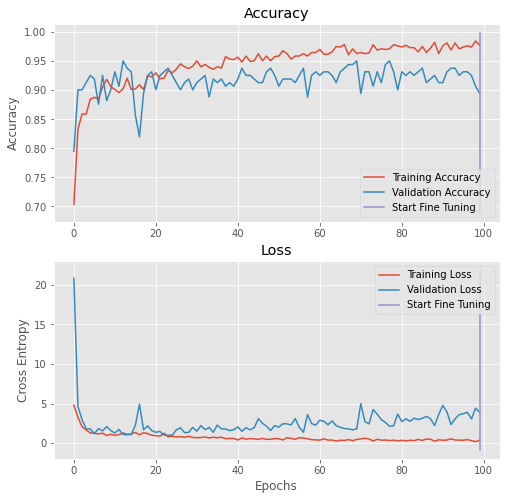

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/4 [======>.......................] - ETA: 0s - loss: 8.6823 - accuracy: 0.7969

2/4 [==============>...............] - ETA: 1s - loss: 5.5306 - accuracy: 0.8672

3/4 [=====================>........] - ETA: 1s - loss: 3.9596 - accuracy: 0.9010

4/4 [==============================] - ETA: 0s - loss: 3.3403 - accuracy: 0.9098

4/4 [==============================] - 13s 3s/step - loss: 3.3403 - accuracy: 0.9098


[3.340254783630371, 0.9098360538482666]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

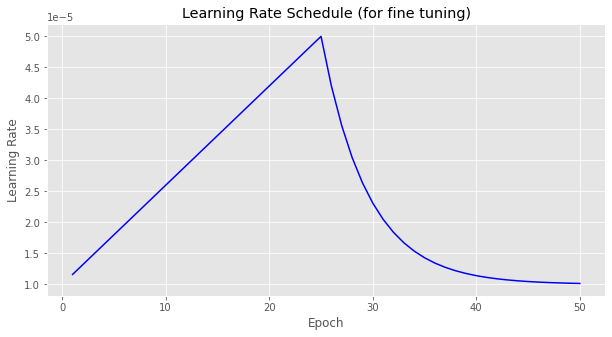

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 971 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3425 - accuracy: 0.9531

 2/16 [==>...........................] - ETA: 4s - loss: 0.3373 - accuracy: 0.9609

 3/16 [====>.........................] - ETA: 10s - loss: 0.6983 - accuracy: 0.9531

 4/16 [======>.......................] - ETA: 11s - loss: 0.6542 - accuracy: 0.9531

 5/16 [========>.....................] - ETA: 11s - loss: 0.5236 - accuracy: 0.9625

 6/16 [==========>...................] - ETA: 11s - loss: 0.4918 - accuracy: 0.9661

 7/16 [============>.................] - ETA: 9s - loss: 0.4648 - accuracy: 0.9688 

 8/16 [==============>...............] - ETA: 8s - loss: 0.4478 - accuracy: 0.9707

 9/16 [===============>..............] - ETA: 7s - loss: 0.5392 - accuracy: 0.9688

10/16 [=================>............] - ETA: 6s - loss: 0.4975 - accuracy: 0.9703

11/16 [===================>..........] - ETA: 5s - loss: 0.4540 - accuracy: 0.9716

12/16 [=====================>........] - ETA: 4s - loss: 0.4326 - accuracy: 0.9727

13/16 [=======================>......] - ETA: 3s - loss: 0.4318 - accuracy: 0.9724

14/16 [=========================>....] - ETA: 2s - loss: 0.4509 - accuracy: 0.9710

15/16 [===========================>..] - ETA: 1s - loss: 0.4606 - accuracy: 0.9698

16/16 [==============================] - ETA: 0s - loss: 0.4554 - accuracy: 0.9701

16/16 [==============================] - 21s 1s/step - loss: 0.4554 - accuracy: 0.9701 - val_loss: 3.6454 - val_accuracy: 0.8944



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/16 [>.............................] - ETA: 0s - loss: 0.7510 - accuracy: 0.9375

 2/16 [==>...........................] - ETA: 5s - loss: 0.3755 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 5s - loss: 0.2518 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 7s - loss: 0.5875 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 9s - loss: 0.4701 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 9s - loss: 0.4685 - accuracy: 0.9714

 7/16 [============>.................] - ETA: 11s - loss: 0.4016 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 10s - loss: 0.3940 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 10s - loss: 0.4164 - accuracy: 0.9722

10/16 [=================>............] - ETA: 8s - loss: 0.3749 - accuracy: 0.9750 

11/16 [===================>..........] - ETA: 6s - loss: 0.3477 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 4s - loss: 0.3404 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.3635 - accuracy: 0.9760

14/16 [=========================>....] - ETA: 2s - loss: 0.4089 - accuracy: 0.9732

15/16 [===========================>..] - ETA: 1s - loss: 0.3985 - accuracy: 0.9740

16/16 [==============================] - ETA: 0s - loss: 0.4453 - accuracy: 0.9732

16/16 [==============================] - 19s 1s/step - loss: 0.4453 - accuracy: 0.9732 - val_loss: 3.4427 - val_accuracy: 0.8944



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/16 [>.............................] - ETA: 0s - loss: 1.2993 - accuracy: 0.9375

 2/16 [==>...........................] - ETA: 8s - loss: 0.6565 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 21s - loss: 1.2607 - accuracy: 0.9583

 4/16 [======>.......................] - ETA: 17s - loss: 0.9594 - accuracy: 0.9648

 5/16 [========>.....................] - ETA: 13s - loss: 0.8383 - accuracy: 0.9688

 6/16 [==========>...................] - ETA: 12s - loss: 0.7453 - accuracy: 0.9688

 7/16 [============>.................] - ETA: 14s - loss: 0.7540 - accuracy: 0.9665

 8/16 [==============>...............] - ETA: 12s - loss: 0.6601 - accuracy: 0.9707

 9/16 [===============>..............] - ETA: 11s - loss: 0.6073 - accuracy: 0.9722

10/16 [=================>............] - ETA: 9s - loss: 0.5648 - accuracy: 0.9734 

11/16 [===================>..........] - ETA: 7s - loss: 0.5211 - accuracy: 0.9744

12/16 [=====================>........] - ETA: 5s - loss: 0.4777 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.4801 - accuracy: 0.9760

14/16 [=========================>....] - ETA: 2s - loss: 0.4593 - accuracy: 0.9766

15/16 [===========================>..] - ETA: 1s - loss: 0.4398 - accuracy: 0.9760

16/16 [==============================] - ETA: 0s - loss: 0.4348 - accuracy: 0.9763

16/16 [==============================] - 21s 1s/step - loss: 0.4348 - accuracy: 0.9763 - val_loss: 3.3306 - val_accuracy: 0.9068



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/16 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 0.0421 - accuracy: 0.9922    

 3/16 [====>.........................] - ETA: 15s - loss: 0.0502 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 12s - loss: 0.1914 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 14s - loss: 0.1915 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 13s - loss: 0.2173 - accuracy: 0.9714

 7/16 [============>.................] - ETA: 11s - loss: 0.1862 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 10s - loss: 0.1717 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 8s - loss: 0.1526 - accuracy: 0.9792 

10/16 [=================>............] - ETA: 7s - loss: 0.1596 - accuracy: 0.9766

11/16 [===================>..........] - ETA: 5s - loss: 0.2538 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 4s - loss: 0.2418 - accuracy: 0.9753

13/16 [=======================>......] - ETA: 3s - loss: 0.2661 - accuracy: 0.9748

14/16 [=========================>....] - ETA: 2s - loss: 0.2473 - accuracy: 0.9766

15/16 [===========================>..] - ETA: 1s - loss: 0.2535 - accuracy: 0.9760

16/16 [==============================] - ETA: 0s - loss: 0.2817 - accuracy: 0.9743

16/16 [==============================] - 19s 1s/step - loss: 0.2817 - accuracy: 0.9743 - val_loss: 3.2518 - val_accuracy: 0.9068



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/16 [>.............................] - ETA: 0s - loss: 1.5793 - accuracy: 0.9219

 2/16 [==>...........................] - ETA: 3s - loss: 0.7897 - accuracy: 0.9609

 3/16 [====>.........................] - ETA: 13s - loss: 1.0360 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 10s - loss: 0.8288 - accuracy: 0.9648

 5/16 [========>.....................] - ETA: 11s - loss: 0.8520 - accuracy: 0.9656

 6/16 [==========>...................] - ETA: 13s - loss: 0.7184 - accuracy: 0.9688

 7/16 [============>.................] - ETA: 10s - loss: 0.6313 - accuracy: 0.9710

 8/16 [==============>...............] - ETA: 11s - loss: 0.5900 - accuracy: 0.9727

 9/16 [===============>..............] - ETA: 9s - loss: 0.5804 - accuracy: 0.9740 

10/16 [=================>............] - ETA: 8s - loss: 0.6074 - accuracy: 0.9734

11/16 [===================>..........] - ETA: 6s - loss: 0.7599 - accuracy: 0.9688

12/16 [=====================>........] - ETA: 5s - loss: 0.7267 - accuracy: 0.9701

13/16 [=======================>......] - ETA: 3s - loss: 0.6708 - accuracy: 0.9724

14/16 [=========================>....] - ETA: 2s - loss: 0.7093 - accuracy: 0.9721

15/16 [===========================>..] - ETA: 1s - loss: 0.6643 - accuracy: 0.9729

16/16 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.9722

16/16 [==============================] - 20s 1s/step - loss: 0.6593 - accuracy: 0.9722 - val_loss: 3.2021 - val_accuracy: 0.9130



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2694 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 13s - loss: 0.2332 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 16s - loss: 0.2961 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 13s - loss: 0.2717 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 13s - loss: 0.2174 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 15s - loss: 0.2959 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 14s - loss: 0.2537 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 12s - loss: 0.2441 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 11s - loss: 0.2170 - accuracy: 0.9809

10/16 [=================>............] - ETA: 9s - loss: 0.3105 - accuracy: 0.9781 

11/16 [===================>..........] - ETA: 7s - loss: 0.3008 - accuracy: 0.9787

12/16 [=====================>........] - ETA: 5s - loss: 0.3678 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 4s - loss: 0.3594 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 2s - loss: 0.3348 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.3346 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.3639 - accuracy: 0.9773

16/16 [==============================] - 22s 1s/step - loss: 0.3639 - accuracy: 0.9773 - val_loss: 3.1828 - val_accuracy: 0.9068



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2645 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 14s - loss: 0.4481 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 13s - loss: 0.4525 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 17s - loss: 0.3540 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 13s - loss: 0.4267 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 14s - loss: 0.3556 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 12s - loss: 0.3049 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 11s - loss: 0.2845 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 10s - loss: 0.2547 - accuracy: 0.9809

10/16 [=================>............] - ETA: 9s - loss: 0.2911 - accuracy: 0.9781 

11/16 [===================>..........] - ETA: 7s - loss: 0.2646 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 5s - loss: 0.2571 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 3s - loss: 0.2629 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.2916 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.2859 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.3235 - accuracy: 0.9773

16/16 [==============================] - 21s 1s/step - loss: 0.3235 - accuracy: 0.9773 - val_loss: 3.1814 - val_accuracy: 0.9068



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/16 [>.............................] - ETA: 0s - loss: 0.7996 - accuracy: 0.9531

 2/16 [==>...........................] - ETA: 3s - loss: 0.9891 - accuracy: 0.9531

 3/16 [====>.........................] - ETA: 16s - loss: 0.7149 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 14s - loss: 0.7084 - accuracy: 0.9570

 5/16 [========>.....................] - ETA: 14s - loss: 0.6741 - accuracy: 0.9594

 6/16 [==========>...................] - ETA: 11s - loss: 0.6014 - accuracy: 0.9635

 7/16 [============>.................] - ETA: 11s - loss: 0.5156 - accuracy: 0.9688

 8/16 [==============>...............] - ETA: 11s - loss: 0.4636 - accuracy: 0.9688

 9/16 [===============>..............] - ETA: 9s - loss: 0.5037 - accuracy: 0.9705 

10/16 [=================>............] - ETA: 8s - loss: 0.4533 - accuracy: 0.9734

11/16 [===================>..........] - ETA: 7s - loss: 0.4121 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 5s - loss: 0.3778 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.3488 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 2s - loss: 0.3409 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.3267 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.9804

16/16 [==============================] - 21s 1s/step - loss: 0.3236 - accuracy: 0.9804 - val_loss: 3.1965 - val_accuracy: 0.9068



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/16 [>.............................] - ETA: 0s - loss: 2.0251 - accuracy: 0.9375

 2/16 [==>...........................] - ETA: 8s - loss: 1.1332 - accuracy: 0.9531

 3/16 [====>.........................] - ETA: 13s - loss: 0.7557 - accuracy: 0.9688

 4/16 [======>.......................] - ETA: 13s - loss: 0.5668 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 14s - loss: 0.7722 - accuracy: 0.9625

 6/16 [==========>...................] - ETA: 15s - loss: 0.6474 - accuracy: 0.9661

 7/16 [============>.................] - ETA: 14s - loss: 0.5553 - accuracy: 0.9710

 8/16 [==============>...............] - ETA: 13s - loss: 0.6437 - accuracy: 0.9688

 9/16 [===============>..............] - ETA: 10s - loss: 0.5721 - accuracy: 0.9722

10/16 [=================>............] - ETA: 9s - loss: 0.5270 - accuracy: 0.9734 

11/16 [===================>..........] - ETA: 7s - loss: 0.4792 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 5s - loss: 0.4781 - accuracy: 0.9740

13/16 [=======================>......] - ETA: 3s - loss: 0.4416 - accuracy: 0.9760

14/16 [=========================>....] - ETA: 2s - loss: 0.4166 - accuracy: 0.9754

15/16 [===========================>..] - ETA: 1s - loss: 0.4020 - accuracy: 0.9760

16/16 [==============================] - ETA: 0s - loss: 0.3974 - accuracy: 0.9763

16/16 [==============================] - 21s 1s/step - loss: 0.3974 - accuracy: 0.9763 - val_loss: 3.1656 - val_accuracy: 0.9068



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/16 [>.............................] - ETA: 0s - loss: 0.4517 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 6s - loss: 0.5800 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 21s - loss: 0.3867 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 21s - loss: 0.2901 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 16s - loss: 0.3954 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 15s - loss: 0.3826 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 14s - loss: 0.3280 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 11s - loss: 0.3030 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 10s - loss: 0.2803 - accuracy: 0.9809

10/16 [=================>............] - ETA: 9s - loss: 0.2524 - accuracy: 0.9828 

11/16 [===================>..........] - ETA: 7s - loss: 0.2428 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 5s - loss: 0.2288 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 4s - loss: 0.2112 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.1961 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.2085 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.2181 - accuracy: 0.9825

16/16 [==============================] - 22s 1s/step - loss: 0.2181 - accuracy: 0.9825 - val_loss: 3.1304 - val_accuracy: 0.9130



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2266 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 7s - loss: 0.2298 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 21s - loss: 0.1532 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 18s - loss: 0.4305 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 20s - loss: 0.4817 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 18s - loss: 0.6943 - accuracy: 0.9661

 7/16 [============>.................] - ETA: 16s - loss: 0.5951 - accuracy: 0.9710

 8/16 [==============>...............] - ETA: 13s - loss: 0.5332 - accuracy: 0.9707

 9/16 [===============>..............] - ETA: 10s - loss: 0.5065 - accuracy: 0.9705

10/16 [=================>............] - ETA: 9s - loss: 0.4563 - accuracy: 0.9734 

11/16 [===================>..........] - ETA: 7s - loss: 0.4828 - accuracy: 0.9716

12/16 [=====================>........] - ETA: 5s - loss: 0.4581 - accuracy: 0.9714

13/16 [=======================>......] - ETA: 4s - loss: 0.4582 - accuracy: 0.9700

14/16 [=========================>....] - ETA: 2s - loss: 0.4520 - accuracy: 0.9710

15/16 [===========================>..] - ETA: 1s - loss: 0.4740 - accuracy: 0.9708

16/16 [==============================] - ETA: 0s - loss: 0.4686 - accuracy: 0.9712

16/16 [==============================] - 22s 1s/step - loss: 0.4686 - accuracy: 0.9712 - val_loss: 3.0891 - val_accuracy: 0.9193



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/16 [>.............................] - ETA: 0s - loss: 0.6892 - accuracy: 0.9375

 2/16 [==>...........................] - ETA: 7s - loss: 0.3446 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 21s - loss: 0.2297 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 17s - loss: 0.2921 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 16s - loss: 0.2504 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 15s - loss: 0.2224 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 12s - loss: 0.2095 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 11s - loss: 0.1833 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 10s - loss: 0.2648 - accuracy: 0.9792

10/16 [=================>............] - ETA: 8s - loss: 0.2392 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 6s - loss: 0.2175 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.2407 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.2691 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.2889 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2812 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.9815

16/16 [==============================] - 21s 1s/step - loss: 0.2852 - accuracy: 0.9815 - val_loss: 3.0645 - val_accuracy: 0.9193



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2866 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 4s - loss: 0.4193 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 5s - loss: 0.4949 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 11s - loss: 0.3986 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 9s - loss: 0.3443 - accuracy: 0.9656 

 6/16 [==========>...................] - ETA: 11s - loss: 0.3374 - accuracy: 0.9688

 7/16 [============>.................] - ETA: 10s - loss: 0.3070 - accuracy: 0.9710

 8/16 [==============>...............] - ETA: 9s - loss: 0.3266 - accuracy: 0.9707 

 9/16 [===============>..............] - ETA: 7s - loss: 0.3397 - accuracy: 0.9705

10/16 [=================>............] - ETA: 6s - loss: 0.3057 - accuracy: 0.9734

11/16 [===================>..........] - ETA: 5s - loss: 0.2779 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 4s - loss: 0.2637 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.2434 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.2367 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.2415 - accuracy: 0.9771

16/16 [==============================] - ETA: 0s - loss: 0.2654 - accuracy: 0.9753

16/16 [==============================] - 19s 1s/step - loss: 0.2654 - accuracy: 0.9753 - val_loss: 3.0598 - val_accuracy: 0.9193



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3678 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 12s - loss: 0.7483 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 17s - loss: 0.6230 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 20s - loss: 0.4673 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 18s - loss: 0.4100 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 15s - loss: 0.3417 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 15s - loss: 0.2944 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 13s - loss: 0.2748 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 11s - loss: 0.2475 - accuracy: 0.9861

10/16 [=================>............] - ETA: 9s - loss: 0.2747 - accuracy: 0.9859 

11/16 [===================>..........] - ETA: 7s - loss: 0.3008 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 5s - loss: 0.2952 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 4s - loss: 0.3002 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.2788 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.2738 - accuracy: 0.9844

16/16 [==============================] - ETA: 0s - loss: 0.2707 - accuracy: 0.9846

16/16 [==============================] - 22s 1s/step - loss: 0.2707 - accuracy: 0.9846 - val_loss: 3.0674 - val_accuracy: 0.9130



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1321 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 10s - loss: 0.2742 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 8s - loss: 0.1828 - accuracy: 0.9792 

 4/16 [======>.......................] - ETA: 17s - loss: 0.1371 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 16s - loss: 0.1202 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 15s - loss: 0.1060 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 12s - loss: 0.0915 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 11s - loss: 0.0801 - accuracy: 0.9883

 9/16 [===============>..............] - ETA: 9s - loss: 0.0934 - accuracy: 0.9861 

10/16 [=================>............] - ETA: 8s - loss: 0.1533 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 6s - loss: 0.1765 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 4s - loss: 0.1618 - accuracy: 0.9857

13/16 [=======================>......] - ETA: 3s - loss: 0.1786 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.1736 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.1620 - accuracy: 0.9854

16/16 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9835

16/16 [==============================] - 19s 1s/step - loss: 0.1816 - accuracy: 0.9835 - val_loss: 3.0559 - val_accuracy: 0.9130



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/16 [>.............................] - ETA: 0s - loss: 6.5750e-07 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 0.6729 - accuracy: 0.9766    

 3/16 [====>.........................] - ETA: 8s - loss: 0.5630 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 9s - loss: 0.4434 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 12s - loss: 0.3547 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 12s - loss: 0.3340 - accuracy: 0.9740

 7/16 [============>.................] - ETA: 10s - loss: 0.3116 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 9s - loss: 0.2726 - accuracy: 0.9766 

 9/16 [===============>..............] - ETA: 8s - loss: 0.2441 - accuracy: 0.9774

10/16 [=================>............] - ETA: 7s - loss: 0.2344 - accuracy: 0.9781

11/16 [===================>..........] - ETA: 6s - loss: 0.2131 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 5s - loss: 0.1954 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.2322 - accuracy: 0.9808

14/16 [=========================>....] - ETA: 2s - loss: 0.2162 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2085 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.2152 - accuracy: 0.9815

16/16 [==============================] - 20s 1s/step - loss: 0.2152 - accuracy: 0.9815 - val_loss: 3.0753 - val_accuracy: 0.9130



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 0.1874 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 7s - loss: 0.2018 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 10s - loss: 0.1817 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 13s - loss: 0.2168 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 12s - loss: 0.2381 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 10s - loss: 0.2041 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 9s - loss: 0.2226 - accuracy: 0.9785 

 9/16 [===============>..............] - ETA: 8s - loss: 0.2147 - accuracy: 0.9774

10/16 [=================>............] - ETA: 6s - loss: 0.1933 - accuracy: 0.9797

11/16 [===================>..........] - ETA: 5s - loss: 0.2298 - accuracy: 0.9787

12/16 [=====================>........] - ETA: 4s - loss: 0.2785 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.2575 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 2s - loss: 0.2999 - accuracy: 0.9754

15/16 [===========================>..] - ETA: 1s - loss: 0.2802 - accuracy: 0.9771

16/16 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.9773

16/16 [==============================] - 19s 1s/step - loss: 0.2770 - accuracy: 0.9773 - val_loss: 3.0677 - val_accuracy: 0.9193



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/16 [>.............................] - ETA: 0s - loss: 5.4516e-05 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 0.1130 - accuracy: 0.9844    

 3/16 [====>.........................] - ETA: 17s - loss: 0.0754 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 15s - loss: 0.2340 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 15s - loss: 0.3847 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 12s - loss: 0.3206 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 14s - loss: 0.2748 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 12s - loss: 0.2472 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 11s - loss: 0.2504 - accuracy: 0.9844

10/16 [=================>............] - ETA: 9s - loss: 0.2311 - accuracy: 0.9844 

11/16 [===================>..........] - ETA: 7s - loss: 0.2458 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.2427 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.2411 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.2240 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.2091 - accuracy: 0.9854

16/16 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.9856

16/16 [==============================] - 21s 1s/step - loss: 0.2067 - accuracy: 0.9856 - val_loss: 3.0442 - val_accuracy: 0.9130



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0774 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 14s - loss: 0.2699 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 13s - loss: 0.1799 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 13s - loss: 0.3906 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 16s - loss: 0.3226 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 14s - loss: 0.2996 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 12s - loss: 0.3643 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 10s - loss: 0.3421 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 8s - loss: 0.3129 - accuracy: 0.9792 

10/16 [=================>............] - ETA: 8s - loss: 0.2816 - accuracy: 0.9812

11/16 [===================>..........] - ETA: 6s - loss: 0.3351 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 5s - loss: 0.3242 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.3279 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 2s - loss: 0.3373 - accuracy: 0.9766

15/16 [===========================>..] - ETA: 1s - loss: 0.3149 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.3113 - accuracy: 0.9784

16/16 [==============================] - 20s 1s/step - loss: 0.3113 - accuracy: 0.9784 - val_loss: 3.0104 - val_accuracy: 0.9130



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1903 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 7s - loss: 0.1042 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 13s - loss: 0.0950 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 12s - loss: 0.0990 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 16s - loss: 0.0794 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 17s - loss: 0.1581 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 16s - loss: 0.2228 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 13s - loss: 0.1949 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 11s - loss: 0.1853 - accuracy: 0.9809

10/16 [=================>............] - ETA: 9s - loss: 0.1996 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 7s - loss: 0.1934 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 5s - loss: 0.1836 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.2263 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 2s - loss: 0.2342 - accuracy: 0.9788

15/16 [===========================>..] - ETA: 1s - loss: 0.2230 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.9794

16/16 [==============================] - 21s 1s/step - loss: 0.2205 - accuracy: 0.9794 - val_loss: 3.0201 - val_accuracy: 0.9130



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/16 [>.............................] - ETA: 0s - loss: 0.4239 - accuracy: 0.9531

 2/16 [==>...........................] - ETA: 3s - loss: 0.2123 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 17s - loss: 0.3556 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 17s - loss: 0.2667 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 13s - loss: 0.3640 - accuracy: 0.9688

 6/16 [==========>...................] - ETA: 13s - loss: 0.3250 - accuracy: 0.9714

 7/16 [============>.................] - ETA: 10s - loss: 0.2798 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 9s - loss: 0.2448 - accuracy: 0.9785 

 9/16 [===============>..............] - ETA: 9s - loss: 0.3519 - accuracy: 0.9757

10/16 [=================>............] - ETA: 8s - loss: 0.3600 - accuracy: 0.9766

11/16 [===================>..........] - ETA: 6s - loss: 0.3463 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 4s - loss: 0.3175 - accuracy: 0.9792

13/16 [=======================>......] - ETA: 3s - loss: 0.3278 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.3421 - accuracy: 0.9788

15/16 [===========================>..] - ETA: 1s - loss: 0.3194 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.3457 - accuracy: 0.9794

16/16 [==============================] - 19s 1s/step - loss: 0.3457 - accuracy: 0.9794 - val_loss: 2.9763 - val_accuracy: 0.9068



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2657 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 5s - loss: 0.3672 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 12s - loss: 0.5628 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 14s - loss: 0.4537 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 18s - loss: 0.3630 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 17s - loss: 0.4070 - accuracy: 0.9740

 7/16 [============>.................] - ETA: 15s - loss: 0.3545 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 12s - loss: 0.3102 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 11s - loss: 0.2757 - accuracy: 0.9809

10/16 [=================>............] - ETA: 9s - loss: 0.2481 - accuracy: 0.9828 

11/16 [===================>..........] - ETA: 7s - loss: 0.2381 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.2183 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.2072 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.2057 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.2073 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9825

16/16 [==============================] - 21s 1s/step - loss: 0.2049 - accuracy: 0.9825 - val_loss: 2.9709 - val_accuracy: 0.9130



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 4s - loss: 0.0121 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 11s - loss: 0.0081 - accuracy: 0.9948

 4/16 [======>.......................] - ETA: 16s - loss: 0.1047 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 13s - loss: 0.0838 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 14s - loss: 0.0698 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 13s - loss: 0.0879 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 11s - loss: 0.0901 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 9s - loss: 0.0801 - accuracy: 0.9861 

10/16 [=================>............] - ETA: 8s - loss: 0.1345 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 7s - loss: 0.1441 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.1321 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.1593 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.1479 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.1581 - accuracy: 0.9844

16/16 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9835

16/16 [==============================] - 21s 1s/step - loss: 0.2022 - accuracy: 0.9835 - val_loss: 2.9850 - val_accuracy: 0.9068



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0621 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 8s - loss: 0.0311 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 16s - loss: 0.0207 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 12s - loss: 0.0683 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 13s - loss: 0.1713 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 14s - loss: 0.1428 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 13s - loss: 0.1497 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 12s - loss: 0.1430 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 11s - loss: 0.1753 - accuracy: 0.9844

10/16 [=================>............] - ETA: 8s - loss: 0.1752 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 6s - loss: 0.1813 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 5s - loss: 0.2457 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 3s - loss: 0.2268 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.2119 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2248 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9804

16/16 [==============================] - 20s 1s/step - loss: 0.2342 - accuracy: 0.9804 - val_loss: 2.9749 - val_accuracy: 0.9068



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/16 [>.............................] - ETA: 0s - loss: 0.5381 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 3s - loss: 0.2837 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 17s - loss: 0.1892 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 16s - loss: 0.1717 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 12s - loss: 0.1990 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 13s - loss: 0.1660 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 11s - loss: 0.1577 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 10s - loss: 0.1817 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 8s - loss: 0.1902 - accuracy: 0.9826 

10/16 [=================>............] - ETA: 7s - loss: 0.2048 - accuracy: 0.9812

11/16 [===================>..........] - ETA: 6s - loss: 0.1865 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.1783 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.1646 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.1542 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.1838 - accuracy: 0.9812

16/16 [==============================] - ETA: 0s - loss: 0.2051 - accuracy: 0.9804

16/16 [==============================] - 20s 1s/step - loss: 0.2051 - accuracy: 0.9804 - val_loss: 2.9797 - val_accuracy: 0.9068



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/16 [>.............................] - ETA: 0s - loss: 1.3534 - accuracy: 0.9531

 2/16 [==>...........................] - ETA: 8s - loss: 0.7017 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 7s - loss: 0.5762 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 8s - loss: 0.4322 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 7s - loss: 0.3457 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 7s - loss: 0.3130 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 8s - loss: 0.3426 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 8s - loss: 0.3248 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 8s - loss: 0.2903 - accuracy: 0.9757

10/16 [=================>............] - ETA: 7s - loss: 0.2613 - accuracy: 0.9781

11/16 [===================>..........] - ETA: 5s - loss: 0.3358 - accuracy: 0.9730

12/16 [=====================>........] - ETA: 4s - loss: 0.3078 - accuracy: 0.9753

13/16 [=======================>......] - ETA: 3s - loss: 0.2888 - accuracy: 0.9760

14/16 [=========================>....] - ETA: 2s - loss: 0.3334 - accuracy: 0.9732

15/16 [===========================>..] - ETA: 0s - loss: 0.3112 - accuracy: 0.9750

16/16 [==============================] - ETA: 0s - loss: 0.3501 - accuracy: 0.9743

16/16 [==============================] - 18s 1s/step - loss: 0.3501 - accuracy: 0.9743 - val_loss: 2.9627 - val_accuracy: 0.9068



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1704 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 18s - loss: 0.3975 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 17s - loss: 0.4267 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 17s - loss: 0.3628 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 17s - loss: 0.4696 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 13s - loss: 0.4688 - accuracy: 0.9714

 7/16 [============>.................] - ETA: 13s - loss: 0.4542 - accuracy: 0.9710

 8/16 [==============>...............] - ETA: 12s - loss: 0.3974 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 10s - loss: 0.3532 - accuracy: 0.9774

10/16 [=================>............] - ETA: 8s - loss: 0.3442 - accuracy: 0.9781 

11/16 [===================>..........] - ETA: 6s - loss: 0.4424 - accuracy: 0.9744

12/16 [=====================>........] - ETA: 5s - loss: 0.4124 - accuracy: 0.9740

13/16 [=======================>......] - ETA: 3s - loss: 0.3806 - accuracy: 0.9760

14/16 [=========================>....] - ETA: 2s - loss: 0.3535 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.3447 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.3484 - accuracy: 0.9773

16/16 [==============================] - 21s 1s/step - loss: 0.3484 - accuracy: 0.9773 - val_loss: 2.9674 - val_accuracy: 0.9068



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/16 [>.............................] - ETA: 0s - loss: 1.7368 - accuracy: 0.9375

 2/16 [==>...........................] - ETA: 8s - loss: 0.8685 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 13s - loss: 0.8532 - accuracy: 0.9531

 4/16 [======>.......................] - ETA: 13s - loss: 0.7174 - accuracy: 0.9609

 5/16 [========>.....................] - ETA: 19s - loss: 0.6212 - accuracy: 0.9625

 6/16 [==========>...................] - ETA: 15s - loss: 0.5394 - accuracy: 0.9661

 7/16 [============>.................] - ETA: 14s - loss: 0.4623 - accuracy: 0.9710

 8/16 [==============>...............] - ETA: 13s - loss: 0.4047 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 11s - loss: 0.3631 - accuracy: 0.9757

10/16 [=================>............] - ETA: 9s - loss: 0.3273 - accuracy: 0.9781 

11/16 [===================>..........] - ETA: 7s - loss: 0.3374 - accuracy: 0.9744

12/16 [=====================>........] - ETA: 5s - loss: 0.3093 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 4s - loss: 0.2898 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 2s - loss: 0.3032 - accuracy: 0.9766

15/16 [===========================>..] - ETA: 1s - loss: 0.2830 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.2798 - accuracy: 0.9784

16/16 [==============================] - 22s 1s/step - loss: 0.2798 - accuracy: 0.9784 - val_loss: 2.9497 - val_accuracy: 0.9068



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3774 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 13s - loss: 0.1888 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 13s - loss: 0.1261 - accuracy: 0.9948

 4/16 [======>.......................] - ETA: 12s - loss: 0.2396 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 16s - loss: 0.3639 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 14s - loss: 0.3039 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 13s - loss: 0.2657 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 13s - loss: 0.2353 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 11s - loss: 0.2104 - accuracy: 0.9826

10/16 [=================>............] - ETA: 9s - loss: 0.2330 - accuracy: 0.9781 

11/16 [===================>..........] - ETA: 7s - loss: 0.2953 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 5s - loss: 0.2879 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 4s - loss: 0.2658 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 2s - loss: 0.2857 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.2666 - accuracy: 0.9812

16/16 [==============================] - ETA: 0s - loss: 0.2636 - accuracy: 0.9815

16/16 [==============================] - 22s 1s/step - loss: 0.2636 - accuracy: 0.9815 - val_loss: 2.9594 - val_accuracy: 0.9068



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/16 [>.............................] - ETA: 0s - loss: 0.9602 - accuracy: 0.9531

 2/16 [==>...........................] - ETA: 13s - loss: 0.9076 - accuracy: 0.9453

 3/16 [====>.........................] - ETA: 10s - loss: 0.7002 - accuracy: 0.9427

 4/16 [======>.......................] - ETA: 11s - loss: 0.6034 - accuracy: 0.9492

 5/16 [========>.....................] - ETA: 9s - loss: 0.6026 - accuracy: 0.9531 

 6/16 [==========>...................] - ETA: 11s - loss: 0.5244 - accuracy: 0.9557

 7/16 [============>.................] - ETA: 11s - loss: 0.4586 - accuracy: 0.9598

 8/16 [==============>...............] - ETA: 11s - loss: 0.4297 - accuracy: 0.9609

 9/16 [===============>..............] - ETA: 10s - loss: 0.3820 - accuracy: 0.9653

10/16 [=================>............] - ETA: 8s - loss: 0.3860 - accuracy: 0.9672 

11/16 [===================>..........] - ETA: 6s - loss: 0.3556 - accuracy: 0.9688

12/16 [=====================>........] - ETA: 5s - loss: 0.3668 - accuracy: 0.9701

13/16 [=======================>......] - ETA: 3s - loss: 0.3545 - accuracy: 0.9712

14/16 [=========================>....] - ETA: 2s - loss: 0.3504 - accuracy: 0.9710

15/16 [===========================>..] - ETA: 1s - loss: 0.3403 - accuracy: 0.9719

16/16 [==============================] - ETA: 0s - loss: 0.3763 - accuracy: 0.9712

16/16 [==============================] - 20s 1s/step - loss: 0.3763 - accuracy: 0.9712 - val_loss: 2.9293 - val_accuracy: 0.9068



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 0.0121 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 10s - loss: 0.1255 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 11s - loss: 0.0944 - accuracy: 0.9922

 5/16 [========>.....................] - ETA: 18s - loss: 0.1427 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 17s - loss: 0.1932 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 16s - loss: 0.2109 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 13s - loss: 0.1846 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 11s - loss: 0.3124 - accuracy: 0.9774

10/16 [=================>............] - ETA: 9s - loss: 0.3100 - accuracy: 0.9750 

11/16 [===================>..........] - ETA: 7s - loss: 0.2818 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 5s - loss: 0.3217 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.2970 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.3010 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.2809 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.2777 - accuracy: 0.9794

16/16 [==============================] - 21s 1s/step - loss: 0.2777 - accuracy: 0.9794 - val_loss: 2.9222 - val_accuracy: 0.9068



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/16 [>.............................] - ETA: 0s - loss: 0.4111 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 13s - loss: 0.3858 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 10s - loss: 0.2573 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 8s - loss: 0.3605 - accuracy: 0.9648 

 5/16 [========>.....................] - ETA: 11s - loss: 0.2884 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 11s - loss: 0.2688 - accuracy: 0.9740

 7/16 [============>.................] - ETA: 9s - loss: 0.2815 - accuracy: 0.9732 

 8/16 [==============>...............] - ETA: 9s - loss: 0.2727 - accuracy: 0.9727

 9/16 [===============>..............] - ETA: 7s - loss: 0.2764 - accuracy: 0.9722

10/16 [=================>............] - ETA: 6s - loss: 0.2488 - accuracy: 0.9750

11/16 [===================>..........] - ETA: 5s - loss: 0.2262 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 4s - loss: 0.2193 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.2429 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.2282 - accuracy: 0.9788

15/16 [===========================>..] - ETA: 1s - loss: 0.2163 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.2598 - accuracy: 0.9773

16/16 [==============================] - 19s 1s/step - loss: 0.2598 - accuracy: 0.9773 - val_loss: 2.9391 - val_accuracy: 0.9130



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/16 [>.............................] - ETA: 0s - loss: 2.0543e-05 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 5s - loss: 0.0989 - accuracy: 0.9922    

 3/16 [====>.........................] - ETA: 8s - loss: 0.0691 - accuracy: 0.9948

 4/16 [======>.......................] - ETA: 9s - loss: 0.0994 - accuracy: 0.9922

 5/16 [========>.....................] - ETA: 17s - loss: 0.1667 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 16s - loss: 0.1405 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 15s - loss: 0.1329 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 12s - loss: 0.2338 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 10s - loss: 0.2097 - accuracy: 0.9826

10/16 [=================>............] - ETA: 8s - loss: 0.3274 - accuracy: 0.9766 

11/16 [===================>..........] - ETA: 6s - loss: 0.2978 - accuracy: 0.9787

12/16 [=====================>........] - ETA: 5s - loss: 0.3424 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.3271 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.3294 - accuracy: 0.9788

15/16 [===========================>..] - ETA: 1s - loss: 0.3180 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.3144 - accuracy: 0.9784

16/16 [==============================] - 20s 1s/step - loss: 0.3144 - accuracy: 0.9784 - val_loss: 2.9266 - val_accuracy: 0.9068



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2667 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 5s - loss: 0.3070 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 5s - loss: 0.2046 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 7s - loss: 0.1535 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 12s - loss: 0.3271 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 11s - loss: 0.2729 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 9s - loss: 0.2340 - accuracy: 0.9844 

 8/16 [==============>...............] - ETA: 9s - loss: 0.2378 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 7s - loss: 0.2165 - accuracy: 0.9844

10/16 [=================>............] - ETA: 6s - loss: 0.2266 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 5s - loss: 0.2140 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 4s - loss: 0.2638 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.2611 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.2573 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.2781 - accuracy: 0.9812

16/16 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.9815

16/16 [==============================] - 19s 1s/step - loss: 0.2750 - accuracy: 0.9815 - val_loss: 2.9316 - val_accuracy: 0.9068



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 6s - loss: 0.1282 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 5s - loss: 0.1980 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 9s - loss: 0.1485 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 12s - loss: 0.1943 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 12s - loss: 0.1621 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 11s - loss: 0.2896 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 9s - loss: 0.2578 - accuracy: 0.9844 

 9/16 [===============>..............] - ETA: 8s - loss: 0.2339 - accuracy: 0.9844

10/16 [=================>............] - ETA: 8s - loss: 0.2566 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 6s - loss: 0.2638 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 4s - loss: 0.2855 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.2635 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 2s - loss: 0.2447 - accuracy: 0.9866

15/16 [===========================>..] - ETA: 1s - loss: 0.2284 - accuracy: 0.9875

16/16 [==============================] - ETA: 0s - loss: 0.2454 - accuracy: 0.9866

16/16 [==============================] - 19s 1s/step - loss: 0.2454 - accuracy: 0.9866 - val_loss: 2.9248 - val_accuracy: 0.9068



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/16 [>.............................] - ETA: 0s - loss: 0.9019 - accuracy: 0.9531

 2/16 [==>...........................] - ETA: 8s - loss: 0.4509 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 18s - loss: 0.3491 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 14s - loss: 0.4917 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 19s - loss: 0.4126 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 18s - loss: 0.3438 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 16s - loss: 0.3581 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 13s - loss: 0.3707 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 11s - loss: 0.3324 - accuracy: 0.9774

10/16 [=================>............] - ETA: 9s - loss: 0.2992 - accuracy: 0.9797 

11/16 [===================>..........] - ETA: 7s - loss: 0.2806 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 5s - loss: 0.2572 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.2825 - accuracy: 0.9808

14/16 [=========================>....] - ETA: 2s - loss: 0.2626 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2511 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.3118 - accuracy: 0.9804

16/16 [==============================] - 21s 1s/step - loss: 0.3118 - accuracy: 0.9804 - val_loss: 2.8963 - val_accuracy: 0.9068



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1487 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 6s - loss: 0.0743 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 17s - loss: 0.2200 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 15s - loss: 0.2449 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 14s - loss: 0.1959 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 14s - loss: 0.2159 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 11s - loss: 0.2404 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 11s - loss: 0.2348 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 9s - loss: 0.3250 - accuracy: 0.9792 

10/16 [=================>............] - ETA: 7s - loss: 0.3034 - accuracy: 0.9797

11/16 [===================>..........] - ETA: 6s - loss: 0.3121 - accuracy: 0.9787

12/16 [=====================>........] - ETA: 5s - loss: 0.2864 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 3s - loss: 0.2801 - accuracy: 0.9808

14/16 [=========================>....] - ETA: 2s - loss: 0.2603 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2600 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.2571 - accuracy: 0.9825

16/16 [==============================] - 20s 1s/step - loss: 0.2571 - accuracy: 0.9825 - val_loss: 2.9138 - val_accuracy: 0.9068



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/16 [>.............................] - ETA: 0s - loss: 1.2364e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 9s - loss: 0.0238 - accuracy: 0.9922    

 3/16 [====>.........................] - ETA: 13s - loss: 0.1708 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 15s - loss: 0.1282 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 19s - loss: 0.1025 - accuracy: 0.9906

 6/16 [==========>...................] - ETA: 18s - loss: 0.1302 - accuracy: 0.9896

 7/16 [============>.................] - ETA: 14s - loss: 0.1465 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 13s - loss: 0.1299 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 11s - loss: 0.1155 - accuracy: 0.9878

10/16 [=================>............] - ETA: 9s - loss: 0.3007 - accuracy: 0.9875 

11/16 [===================>..........] - ETA: 7s - loss: 0.3022 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 5s - loss: 0.2770 - accuracy: 0.9870

13/16 [=======================>......] - ETA: 3s - loss: 0.2896 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 2s - loss: 0.3583 - accuracy: 0.9855

15/16 [===========================>..] - ETA: 1s - loss: 0.3359 - accuracy: 0.9854

16/16 [==============================] - ETA: 0s - loss: 0.3832 - accuracy: 0.9835

16/16 [==============================] - 21s 1s/step - loss: 0.3832 - accuracy: 0.9835 - val_loss: 2.9260 - val_accuracy: 0.9068



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/16 [>.............................] - ETA: 0s - loss: 5.3085e-05 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 13s - loss: 0.2433 - accuracy: 0.9844   

 3/16 [====>.........................] - ETA: 16s - loss: 0.4499 - accuracy: 0.9688

 4/16 [======>.......................] - ETA: 12s - loss: 0.3374 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 16s - loss: 0.3615 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 13s - loss: 0.3451 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 14s - loss: 0.3192 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 11s - loss: 0.2967 - accuracy: 0.9727

 9/16 [===============>..............] - ETA: 10s - loss: 0.2801 - accuracy: 0.9740

10/16 [=================>............] - ETA: 9s - loss: 0.2521 - accuracy: 0.9766 

11/16 [===================>..........] - ETA: 7s - loss: 0.2571 - accuracy: 0.9744

12/16 [=====================>........] - ETA: 5s - loss: 0.2357 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 4s - loss: 0.2178 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.2243 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.2093 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9794

16/16 [==============================] - 22s 1s/step - loss: 0.2069 - accuracy: 0.9794 - val_loss: 2.8820 - val_accuracy: 0.9068



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/16 [>.............................] - ETA: 0s - loss: 0.4646 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 7s - loss: 0.2323 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 21s - loss: 0.1549 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 19s - loss: 0.1162 - accuracy: 0.9922

 5/16 [========>.....................] - ETA: 15s - loss: 0.1026 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 15s - loss: 0.1698 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 14s - loss: 0.1603 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 13s - loss: 0.1925 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 10s - loss: 0.2322 - accuracy: 0.9826

10/16 [=================>............] - ETA: 9s - loss: 0.2225 - accuracy: 0.9828 

11/16 [===================>..........] - ETA: 7s - loss: 0.2399 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 5s - loss: 0.2805 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 3s - loss: 0.2589 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.2575 - accuracy: 0.9810

15/16 [===========================>..] - ETA: 1s - loss: 0.2404 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.2376 - accuracy: 0.9825

16/16 [==============================] - 21s 1s/step - loss: 0.2376 - accuracy: 0.9825 - val_loss: 2.8873 - val_accuracy: 0.9068



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/16 [>.............................] - ETA: 0s - loss: 1.0190 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 13s - loss: 0.5276 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 21s - loss: 0.7644 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 18s - loss: 0.7340 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 14s - loss: 0.5872 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 13s - loss: 0.4894 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 14s - loss: 0.4367 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 13s - loss: 0.4100 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 10s - loss: 0.3644 - accuracy: 0.9826

10/16 [=================>............] - ETA: 9s - loss: 0.3280 - accuracy: 0.9844 

11/16 [===================>..........] - ETA: 7s - loss: 0.2982 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 5s - loss: 0.3014 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 4s - loss: 0.2827 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.3049 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.3864 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.3820 - accuracy: 0.9804

16/16 [==============================] - 22s 1s/step - loss: 0.3820 - accuracy: 0.9804 - val_loss: 2.8302 - val_accuracy: 0.9068



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/16 [>.............................] - ETA: 0s - loss: 1.3380 - accuracy: 0.9531

 2/16 [==>...........................] - ETA: 3s - loss: 0.7101 - accuracy: 0.9609

 3/16 [====>.........................] - ETA: 13s - loss: 0.4735 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 11s - loss: 0.4002 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 13s - loss: 0.3329 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 14s - loss: 0.3740 - accuracy: 0.9714

 7/16 [============>.................] - ETA: 14s - loss: 0.3206 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 12s - loss: 0.2805 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 11s - loss: 0.4218 - accuracy: 0.9757

10/16 [=================>............] - ETA: 8s - loss: 0.4118 - accuracy: 0.9719 

11/16 [===================>..........] - ETA: 7s - loss: 0.3774 - accuracy: 0.9730

12/16 [=====================>........] - ETA: 5s - loss: 0.3459 - accuracy: 0.9753

13/16 [=======================>......] - ETA: 3s - loss: 0.3365 - accuracy: 0.9736

14/16 [=========================>....] - ETA: 2s - loss: 0.3324 - accuracy: 0.9732

15/16 [===========================>..] - ETA: 1s - loss: 0.3141 - accuracy: 0.9740

16/16 [==============================] - ETA: 0s - loss: 0.3819 - accuracy: 0.9722

16/16 [==============================] - 21s 1s/step - loss: 0.3819 - accuracy: 0.9722 - val_loss: 2.8552 - val_accuracy: 0.9130



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/16 [>.............................] - ETA: 0s - loss: 0.8320 - accuracy: 0.9531

 2/16 [==>...........................] - ETA: 3s - loss: 0.4160 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 11s - loss: 0.4006 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 13s - loss: 0.3435 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 14s - loss: 0.2807 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 14s - loss: 0.2789 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 14s - loss: 0.2440 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 12s - loss: 0.3249 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 11s - loss: 0.3436 - accuracy: 0.9705

10/16 [=================>............] - ETA: 9s - loss: 0.3092 - accuracy: 0.9734 

11/16 [===================>..........] - ETA: 7s - loss: 0.2811 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 5s - loss: 0.2577 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.2379 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 2s - loss: 0.2690 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.2667 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.2636 - accuracy: 0.9794

16/16 [==============================] - 21s 1s/step - loss: 0.2636 - accuracy: 0.9794 - val_loss: 2.8611 - val_accuracy: 0.9068



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/16 [>.............................] - ETA: 0s - loss: 5.2406e-06 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 10s - loss: 7.5480e-04 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 10s - loss: 5.4759e-04 - accuracy: 1.0000

 4/16 [======>.......................] - ETA: 11s - loss: 5.1806e-04 - accuracy: 1.0000

 5/16 [========>.....................] - ETA: 12s - loss: 4.2819e-04 - accuracy: 1.0000

 6/16 [==========>...................] - ETA: 14s - loss: 0.0554 - accuracy: 0.9922    

 7/16 [============>.................] - ETA: 13s - loss: 0.0736 - accuracy: 0.9911

 8/16 [==============>...............] - ETA: 12s - loss: 0.1826 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 10s - loss: 0.2630 - accuracy: 0.9809

10/16 [=================>............] - ETA: 8s - loss: 0.2367 - accuracy: 0.9828 

11/16 [===================>..........] - ETA: 7s - loss: 0.2152 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 5s - loss: 0.2017 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.2056 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.2304 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2207 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.2182 - accuracy: 0.9825

16/16 [==============================] - 21s 1s/step - loss: 0.2182 - accuracy: 0.9825 - val_loss: 2.8346 - val_accuracy: 0.9068



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2743 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 8s - loss: 0.2188 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 14s - loss: 0.1469 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 13s - loss: 0.5571 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 19s - loss: 0.5510 - accuracy: 0.9656

 6/16 [==========>...................] - ETA: 18s - loss: 0.4838 - accuracy: 0.9635

 7/16 [============>.................] - ETA: 16s - loss: 0.4147 - accuracy: 0.9688

 8/16 [==============>...............] - ETA: 13s - loss: 0.4312 - accuracy: 0.9668

 9/16 [===============>..............] - ETA: 11s - loss: 0.4174 - accuracy: 0.9670

10/16 [=================>............] - ETA: 9s - loss: 0.3757 - accuracy: 0.9703 

11/16 [===================>..........] - ETA: 7s - loss: 0.3878 - accuracy: 0.9688

12/16 [=====================>........] - ETA: 5s - loss: 0.3555 - accuracy: 0.9714

13/16 [=======================>......] - ETA: 3s - loss: 0.4725 - accuracy: 0.9675

14/16 [=========================>....] - ETA: 2s - loss: 0.4510 - accuracy: 0.9688

15/16 [===========================>..] - ETA: 1s - loss: 0.4347 - accuracy: 0.9698

16/16 [==============================] - ETA: 0s - loss: 0.4298 - accuracy: 0.9701

16/16 [==============================] - 21s 1s/step - loss: 0.4298 - accuracy: 0.9701 - val_loss: 2.8459 - val_accuracy: 0.9068



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0227 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 10s - loss: 0.0340 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 11s - loss: 0.3196 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 14s - loss: 0.3642 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 15s - loss: 0.3293 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 15s - loss: 0.3014 - accuracy: 0.9740

 7/16 [============>.................] - ETA: 14s - loss: 0.2584 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 11s - loss: 0.2469 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 10s - loss: 0.3907 - accuracy: 0.9740

10/16 [=================>............] - ETA: 8s - loss: 0.3516 - accuracy: 0.9766 

11/16 [===================>..........] - ETA: 6s - loss: 0.3437 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 5s - loss: 0.3151 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.2994 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.2780 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.2595 - accuracy: 0.9812

16/16 [==============================] - ETA: 0s - loss: 0.2566 - accuracy: 0.9815

16/16 [==============================] - 20s 1s/step - loss: 0.2566 - accuracy: 0.9815 - val_loss: 2.8643 - val_accuracy: 0.9068



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2264 - accuracy: 0.9531

 2/16 [==>...........................] - ETA: 13s - loss: 0.5149 - accuracy: 0.9297

 3/16 [====>.........................] - ETA: 13s - loss: 0.3966 - accuracy: 0.9427

 4/16 [======>.......................] - ETA: 14s - loss: 0.3812 - accuracy: 0.9531

 5/16 [========>.....................] - ETA: 19s - loss: 0.4351 - accuracy: 0.9594

 6/16 [==========>...................] - ETA: 17s - loss: 0.3627 - accuracy: 0.9661

 7/16 [============>.................] - ETA: 16s - loss: 0.3109 - accuracy: 0.9710

 8/16 [==============>...............] - ETA: 13s - loss: 0.3661 - accuracy: 0.9707

 9/16 [===============>..............] - ETA: 11s - loss: 0.3566 - accuracy: 0.9705

10/16 [=================>............] - ETA: 9s - loss: 0.3437 - accuracy: 0.9719 

11/16 [===================>..........] - ETA: 7s - loss: 0.3125 - accuracy: 0.9744

12/16 [=====================>........] - ETA: 5s - loss: 0.2871 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 4s - loss: 0.2651 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.2655 - accuracy: 0.9788

15/16 [===========================>..] - ETA: 1s - loss: 0.2496 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.2468 - accuracy: 0.9794

16/16 [==============================] - 21s 1s/step - loss: 0.2468 - accuracy: 0.9794 - val_loss: 2.8686 - val_accuracy: 0.9068



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0737 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 7s - loss: 0.2308 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 18s - loss: 0.1752 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 14s - loss: 0.2854 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 19s - loss: 0.2583 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 17s - loss: 0.2153 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 16s - loss: 0.1846 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 13s - loss: 0.1650 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 11s - loss: 0.1678 - accuracy: 0.9774

10/16 [=================>............] - ETA: 9s - loss: 0.1510 - accuracy: 0.9797 

11/16 [===================>..........] - ETA: 7s - loss: 0.1824 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 5s - loss: 0.2585 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.2689 - accuracy: 0.9748

14/16 [=========================>....] - ETA: 2s - loss: 0.3078 - accuracy: 0.9732

15/16 [===========================>..] - ETA: 1s - loss: 0.2949 - accuracy: 0.9729

16/16 [==============================] - ETA: 0s - loss: 0.3083 - accuracy: 0.9722

16/16 [==============================] - 21s 1s/step - loss: 0.3083 - accuracy: 0.9722 - val_loss: 2.8739 - val_accuracy: 0.9068



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/16 [>.............................] - ETA: 0s - loss: 5.3102e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 13s - loss: 0.0624 - accuracy: 0.9922   

 3/16 [====>.........................] - ETA: 16s - loss: 0.1417 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 14s - loss: 0.1068 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 14s - loss: 0.0854 - accuracy: 0.9906

 6/16 [==========>...................] - ETA: 12s - loss: 0.1034 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 14s - loss: 0.1074 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 12s - loss: 0.0940 - accuracy: 0.9883

 9/16 [===============>..............] - ETA: 11s - loss: 0.1107 - accuracy: 0.9878

10/16 [=================>............] - ETA: 9s - loss: 0.1076 - accuracy: 0.9875 

11/16 [===================>..........] - ETA: 7s - loss: 0.1055 - accuracy: 0.9872

12/16 [=====================>........] - ETA: 5s - loss: 0.0967 - accuracy: 0.9883

13/16 [=======================>......] - ETA: 3s - loss: 0.0892 - accuracy: 0.9892

14/16 [=========================>....] - ETA: 2s - loss: 0.0992 - accuracy: 0.9888

15/16 [===========================>..] - ETA: 1s - loss: 0.0973 - accuracy: 0.9885

16/16 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9887

16/16 [==============================] - 21s 1s/step - loss: 0.0962 - accuracy: 0.9887 - val_loss: 2.8915 - val_accuracy: 0.9068



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0619 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 9s - loss: 0.1123 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 8s - loss: 0.1473 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 9s - loss: 0.4915 - accuracy: 0.9609

 5/16 [========>.....................] - ETA: 13s - loss: 0.4378 - accuracy: 0.9656

 6/16 [==========>...................] - ETA: 12s - loss: 0.3649 - accuracy: 0.9714

 7/16 [============>.................] - ETA: 10s - loss: 0.3128 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 9s - loss: 0.2755 - accuracy: 0.9766 

 9/16 [===============>..............] - ETA: 7s - loss: 0.2449 - accuracy: 0.9792

10/16 [=================>............] - ETA: 6s - loss: 0.2292 - accuracy: 0.9797

11/16 [===================>..........] - ETA: 5s - loss: 0.2329 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 4s - loss: 0.2216 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 3s - loss: 0.2045 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.1899 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.1774 - accuracy: 0.9844

16/16 [==============================] - ETA: 0s - loss: 0.1754 - accuracy: 0.9846

16/16 [==============================] - 19s 1s/step - loss: 0.1754 - accuracy: 0.9846 - val_loss: 2.9003 - val_accuracy: 0.9068


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

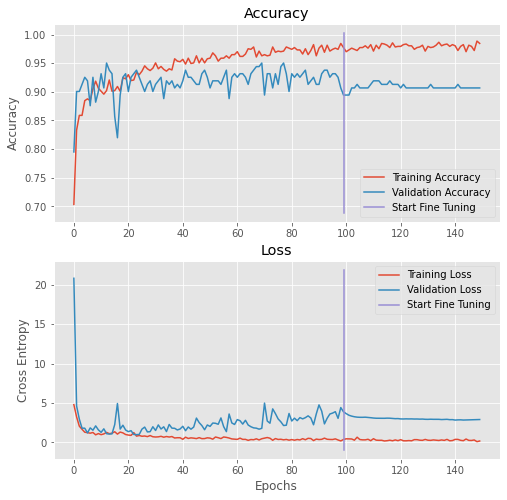

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/4 [======>.......................] - ETA: 0s - loss: 3.8245 - accuracy: 0.8906

2/4 [==============>...............] - ETA: 1s - loss: 2.6529 - accuracy: 0.9180

3/4 [=====================>........] - ETA: 1s - loss: 1.9372 - accuracy: 0.9375

4/4 [==============================] - ETA: 0s - loss: 1.6853 - accuracy: 0.9406

4/4 [==============================] - 5s 1s/step - loss: 1.6853 - accuracy: 0.9406


[1.6853009462356567, 0.9405737519264221]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9405737704918032
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       148
           1       0.95      0.97      0.96       340

    accuracy                           0.94       488
   macro avg       0.94      0.92      0.93       488
weighted avg       0.94      0.94      0.94       488



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

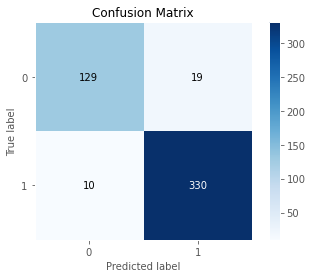

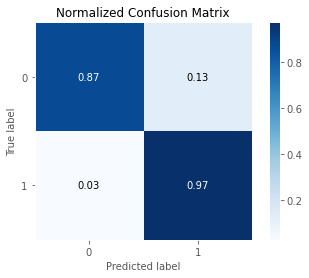

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

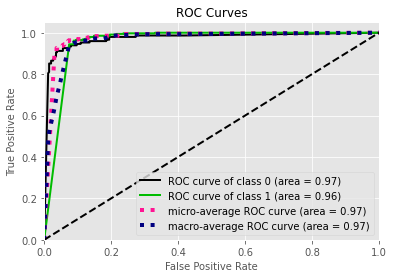

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       148
           1       0.95      0.97      0.96       340

    accuracy                           0.94       488
   macro avg       0.94      0.92      0.93       488
weighted avg       0.94      0.94      0.94       488

                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.87      0.97      0.90      0.92      0.84       148
          1       0.95      0.97      0.87      0.96      0.92      0.85       340

avg / total       0.94      0.94      0.90      0.94      0.92      0.85       488

